In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import numpy as np
import simpleaudio as sa
from scipy.io import wavfile
from pydub import AudioSegment
import librosa
import sklearn

In [2]:
def PrintArrayInfo(a,name=''):
    if (len(name)==0):
        print("Array info:")
    else:
        print("Array:", name)
    print("shape:", a.shape)
    print("dtype:", a.dtype)
    print("min, max:", a.min(), a.max())
    print()

## Stephan's Quintet

In [3]:
stephan = 'stephans.wav'

wave_obj = sa.WaveObject.from_wave_file(stephan)
play_obj = wave_obj.play()
play_obj.wait_done() 

In [4]:
stephan_rate, stephan_data = wavfile.read(stephan)
print("Data rate [units of Hz = 1/seconds] = ",stephan_rate)
PrintArrayInfo(stephan_data,"data")

Data rate [units of Hz = 1/seconds] =  48000
Array: data
shape: (1632000, 2)
dtype: int16
min, max: -23073 22185



/var/folders/kx/dmj5w04s73778pjrrd_ttfwm0000gn/T/ipykernel_29644/2400976459.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  stephan_rate, stephan_data = wavfile.read(stephan)


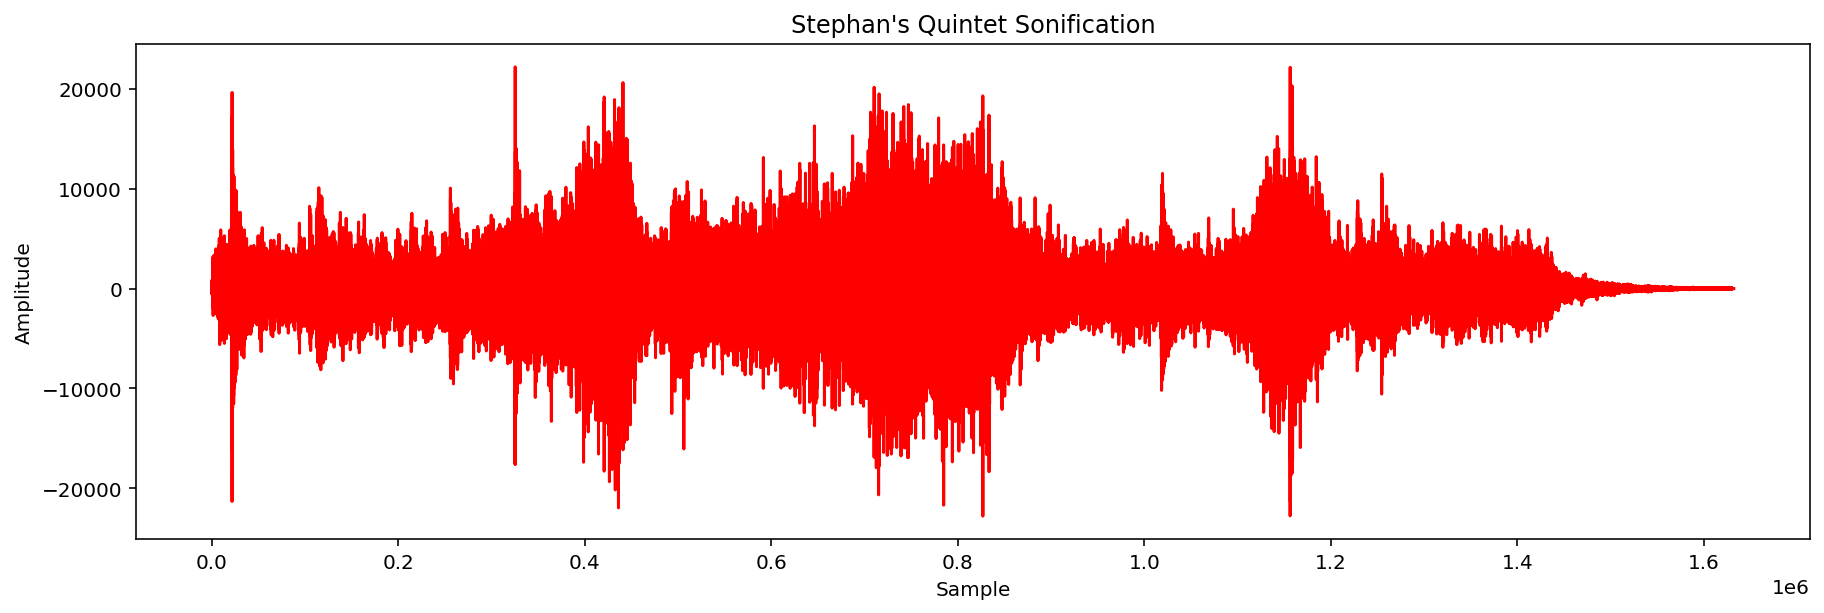

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


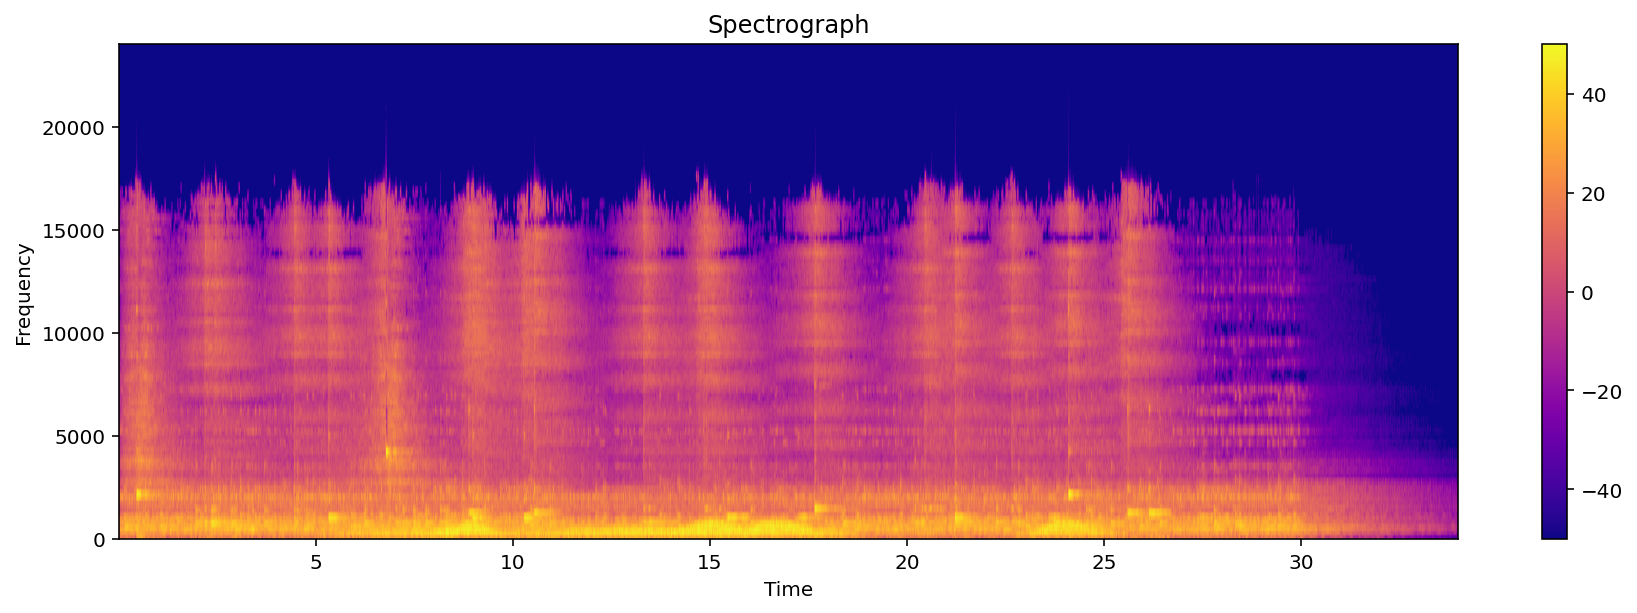

In [5]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.subplot(211)
plt.plot(stephan_data[:,0],'r-')
plt.title("Stephan's Quintet Sonification")
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

plt.subplot(212)
plt.specgram(stephan_data[:,0], Fs = stephan_rate, cmap='plasma',vmin=-50, vmax=50)
plt.colorbar()
plt.title('Spectrograph')
plt.ylabel('Frequency')
plt.xlabel('Time')
#plt.ylim(0,10000)
plt.show()

In [6]:
frame_size = 1024
hop_length = 512

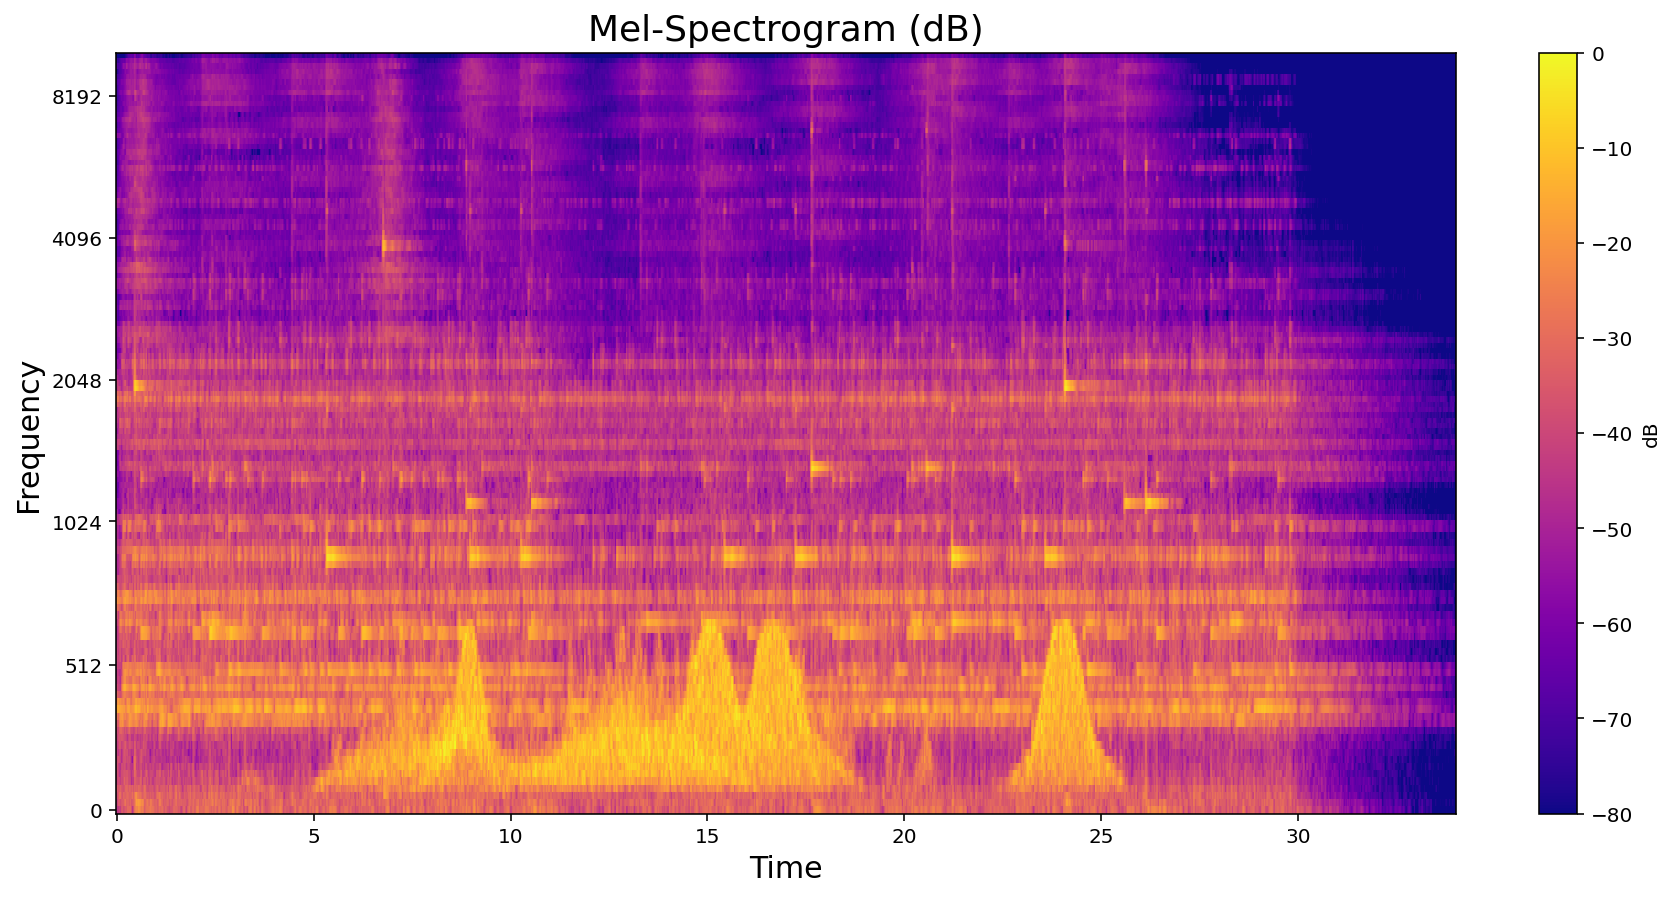

In [7]:
y_stephan, sr_stephan = librosa.load('stephans.wav')
mel_spec_stephan = librosa.feature.melspectrogram(y=y_stephan, sr=sr_stephan)

#spectrogram = np.abs(mel_spec_light)
s_stephan_dB = librosa.power_to_db(mel_spec_stephan, ref=np.max)

plt.figure(figsize=(15, 7))
librosa.display.specshow(s_stephan_dB, sr=sr_stephan, x_axis='time', y_axis='mel', cmap='plasma', 
  hop_length=hop_length, fmax=10000)
plt.colorbar(label='dB')
plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

## Animate Mel Spectrogram

In [8]:
import matplotlib.animation as manimation
import wave

from matplotlib.ticker import FuncFormatter
from matplotlib.animation import FFMpegWriter

In [18]:
hop_length = 512

def kilo(x, pos):
    return '%1.fk' % (x*1e-3)

def vidwav(wavfile, fps=25):

    metadata = dict(title='Wav Spectrogram', artist='Matplotlib', comment='')
    writer = FFMpegWriter(fps=fps, metadata=metadata, bitrate=3500)
    
    wf = wave.open(wavfile, 'rb')
    
    fs = wf.getframerate()
    N = wf.getnframes()
    duration = N/float(fs)
    bytes_per_sample = wf.getsampwidth()
    bits_per_sample  = bytes_per_sample * 8
    dtype = 'int{0}'.format(bits_per_sample)
    channels = wf.getnchannels()
    
    audio = np.frombuffer(wf.readframes(int(duration*fs*bytes_per_sample/channels)), dtype=dtype)
    audio.shape = (int(audio.shape[0]/channels), channels)
    freqs = np.fft.fftfreq(audio[:,0].shape[0], 1.0/fs) / 1000.0
    max_freq_kHz = freqs.max()
    times = np.arange(audio.shape[0]) / float(fs)
    
    fig = plt.figure(figsize=(6.4, 4.8))
    
    plt.subplot(211)
    # first plot is waveform
    plt.plot(times, (audio[:,0]).astype(float)/np.max(np.abs(audio[:,0])), c='r', lw=.3)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude ')

    plt.xlim(0,duration)
    plt.ylim(-1,1)
    
    l1, = plt.plot([], [], '#333333', lw=2)
    
    plt.subplot(212)
    # second plot is mel-spectrogram
    y_audio, sr_audio = librosa.load(wavfile)
    mel_audio_light = librosa.feature.melspectrogram(y=y_audio, sr=sr_audio)
    s_audio_dB = librosa.power_to_db(mel_audio_light, ref=np.max)
    
    librosa.display.specshow(s_audio_dB, sr=sr_audio, x_axis='time', y_axis='mel', cmap='plasma', 
      hop_length=hop_length, fmax=8000)
    plt.xlim(0,duration)
    plt.ylim(0,8000)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    formatter = FuncFormatter(kilo)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(formatter)
    
    l2, = plt.plot([], [], '#333333', lw=2)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.09, 
                                 right=0.98, 
                                 top=0.98, 
                                 left=0.08, 
                                 hspace=0.14)
    
    x = np.array([0., 0.])
    y0 = np.array([-1, 1])
    y1 = np.array([0, max_freq_kHz*1000.0])
    
    with writer.saving(fig, "temp.mp4", 100):
        for i in range((int(duration)+1)*fps):
            x += 1.0/float(fps)
            l1.set_data(x,y0)
            l2.set_data(x,y1)
            writer.grab_frame()
    
    import os
    os.system('ffmpeg -y -i "'+wavfile+'" -i temp.mp4 -c:v copy -strict -2 "'+wavfile.split('.')[0]+'.mp4"')
    os.remove("temp.mp4")


## Black Hole

In [19]:
BH = 'bh_perseus.wav'

wave_obj = sa.WaveObject.from_wave_file(BH)
play_obj = wave_obj.play()
play_obj.wait_done() 

Data rate [units of Hz = 1/seconds] =  44100
Array: data
shape: (1502208, 2)
dtype: int16
min, max: -29140 31022



/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


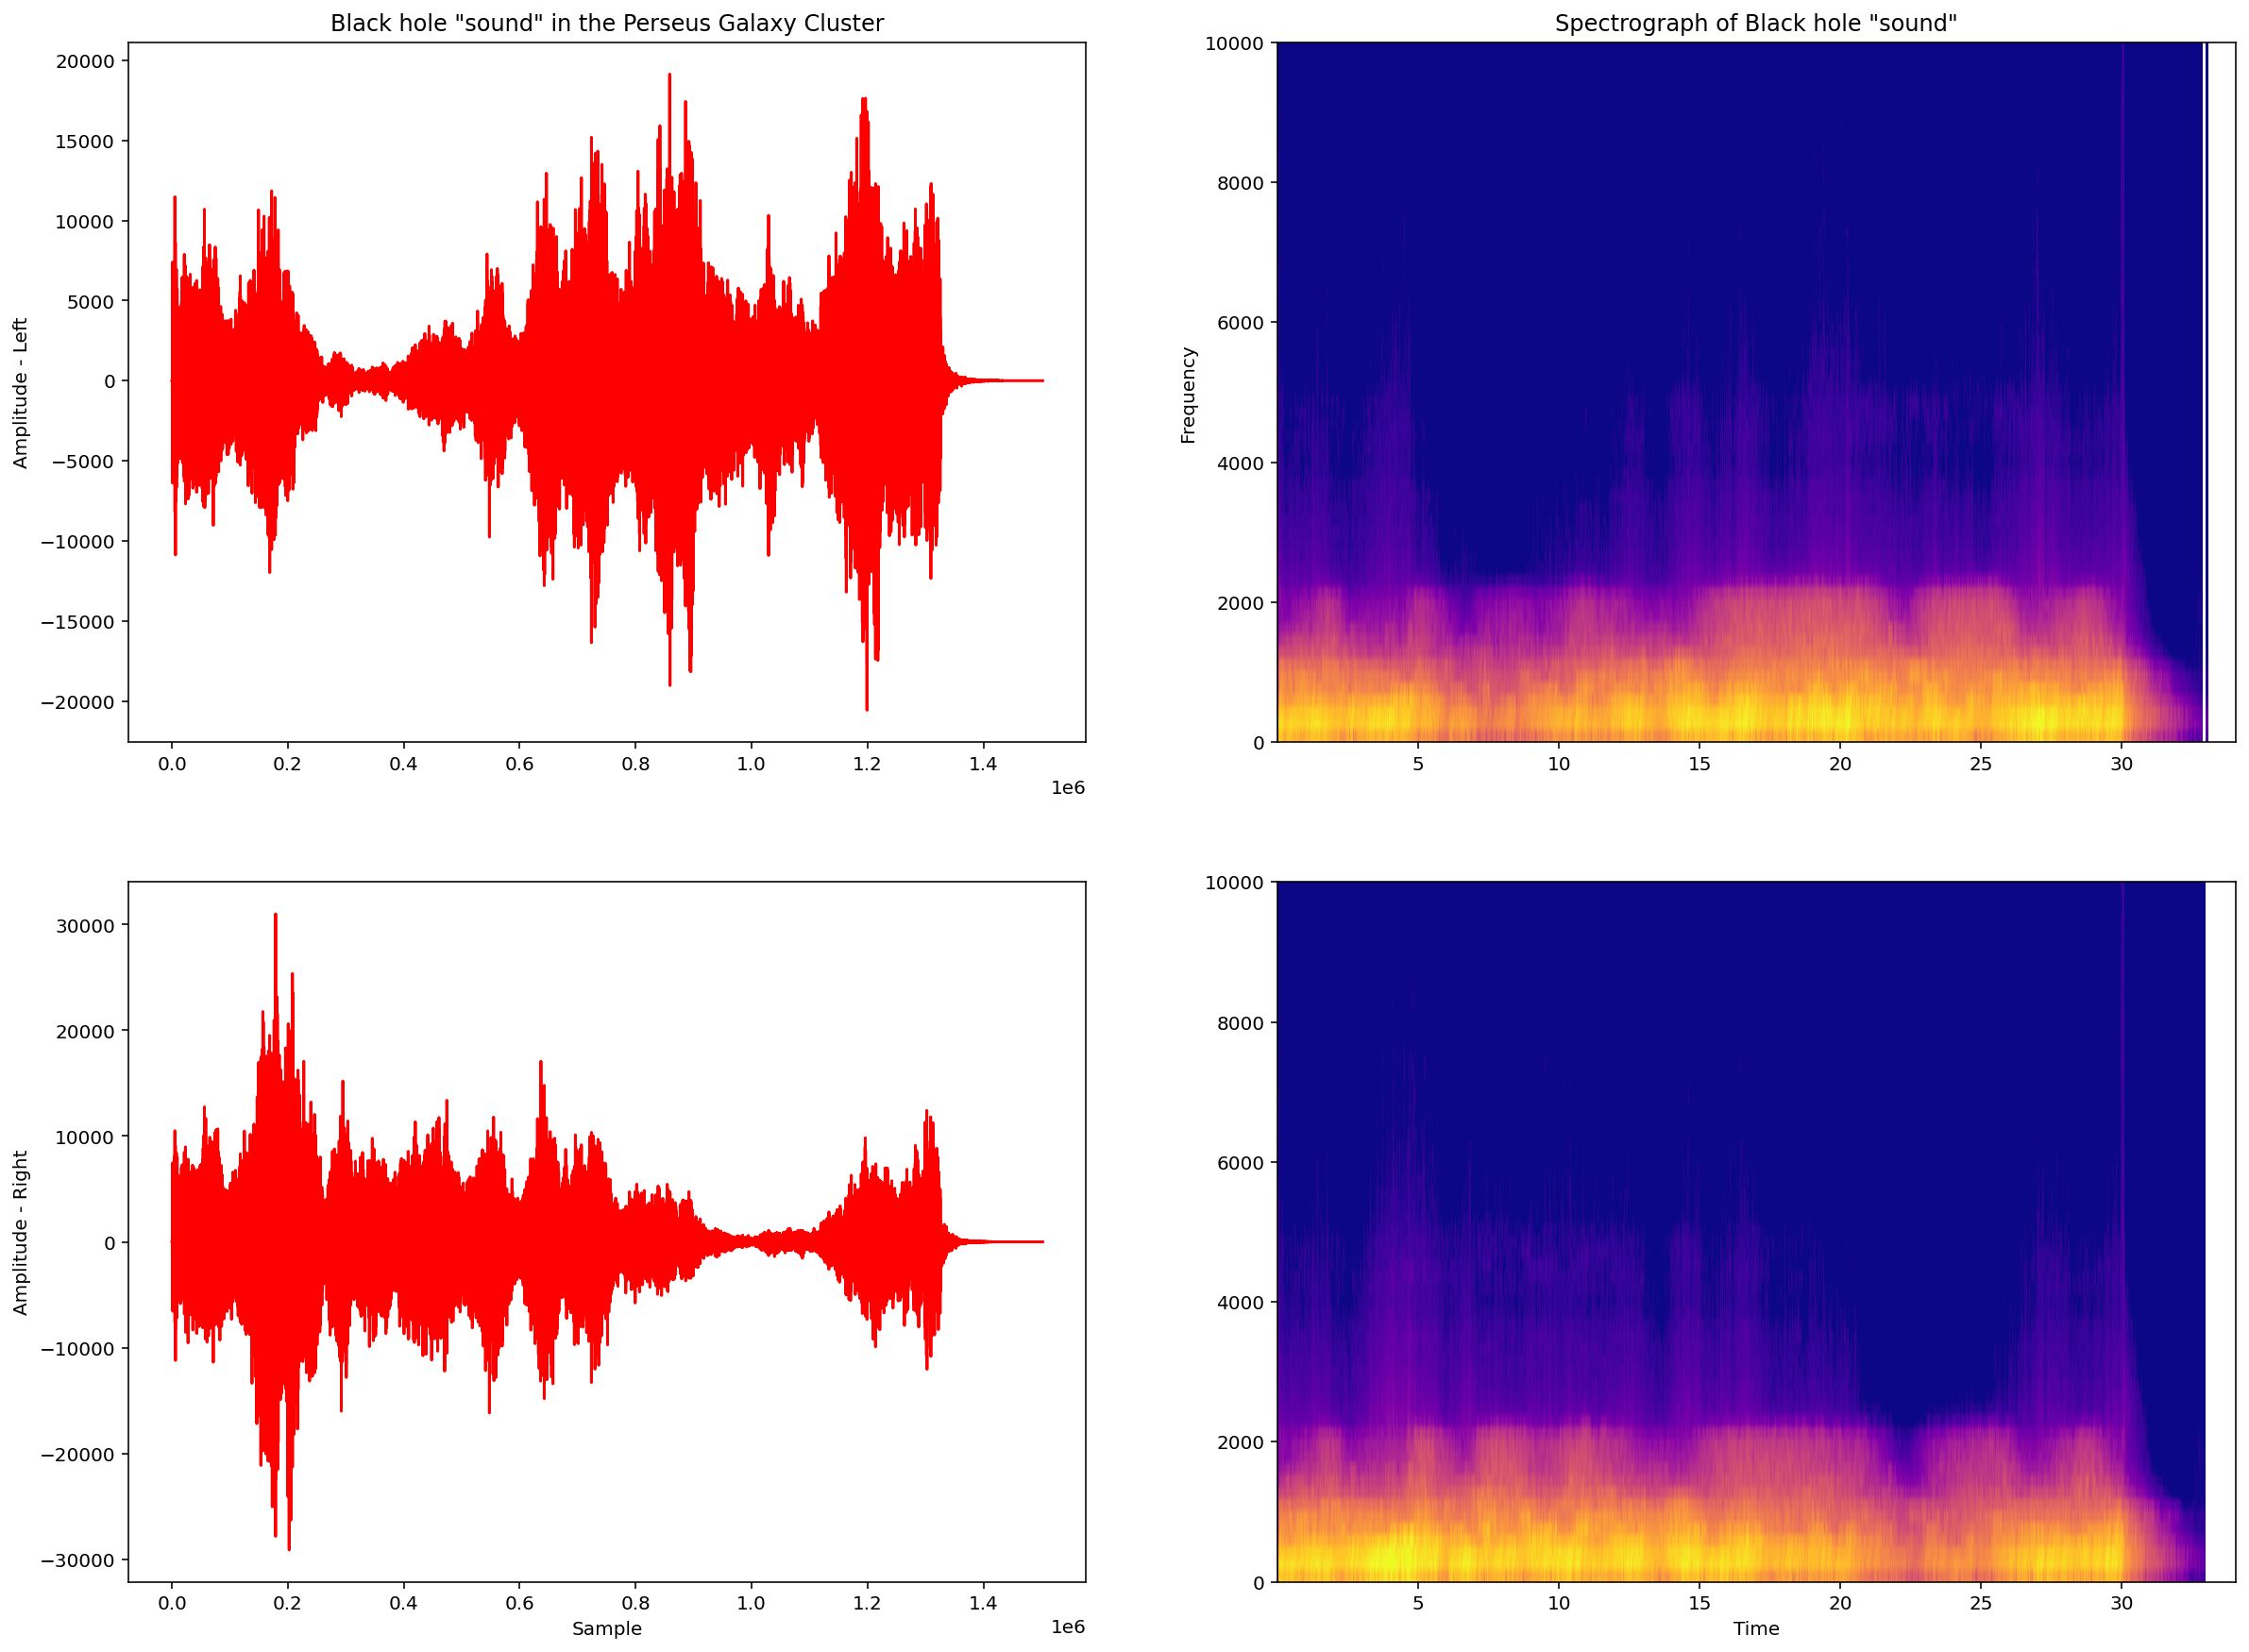

In [20]:
BH_rate, BH_data = wavfile.read(BH)
print("Data rate [units of Hz = 1/seconds] = ",BH_rate)
PrintArrayInfo(BH_data,"data")

plt.rcParams['figure.figsize'] = [20, 15]

fig, axs = plt.subplots(2, 2)

axs[0,0].plot(BH_data[:,0],'r-')
axs[0,0].set_title('Black hole "sound" in the Perseus Galaxy Cluster')
axs[0,0].set_ylabel('Amplitude - Left')

axs[0,1].specgram(BH_data[:,0], Fs = BH_rate, cmap='plasma',vmin=-50, vmax=50)
#axs[0,0].colorbar()
axs[0,1].set_title('Spectrograph of Black hole "sound"')
axs[0,1].set_ylabel('Frequency')
axs[0,1].set_ylim(0,10000)

axs[1,0].plot(BH_data[:,1],'r-')
axs[1,0].set_xlabel('Sample')
axs[1,0].set_ylabel('Amplitude - Right')

axs[1,1].specgram(BH_data[:,1], Fs = BH_rate, cmap='plasma',vmin=-50, vmax=50)
#plt.colorbar()
axs[1,1].set_xlabel('Time')
axs[1,1].set_ylim(0,10000)

plt.show()

In [21]:
# combined sound
sound = AudioSegment.from_wav(BH)
sound = sound.set_channels(1)
BH_mono = BH[:-4]+'_mono.wav'
sound.export(BH_mono,format="wav")

<_io.BufferedRandom name='bh_perseus_mono.wav'>

In [22]:
BHM_rate, BHM_data = wavfile.read(BH_mono)
print("Data rate [units of Hz = 1/seconds] = ",BHM_rate)
PrintArrayInfo(BHM_data,"data")

Data rate [units of Hz = 1/seconds] =  44100
Array: data
shape: (1502208,)
dtype: int16
min, max: -17991 19243



In [23]:
wave_obj = sa.WaveObject.from_wave_file(BH_mono)
play_obj = wave_obj.play()
play_obj.wait_done() 

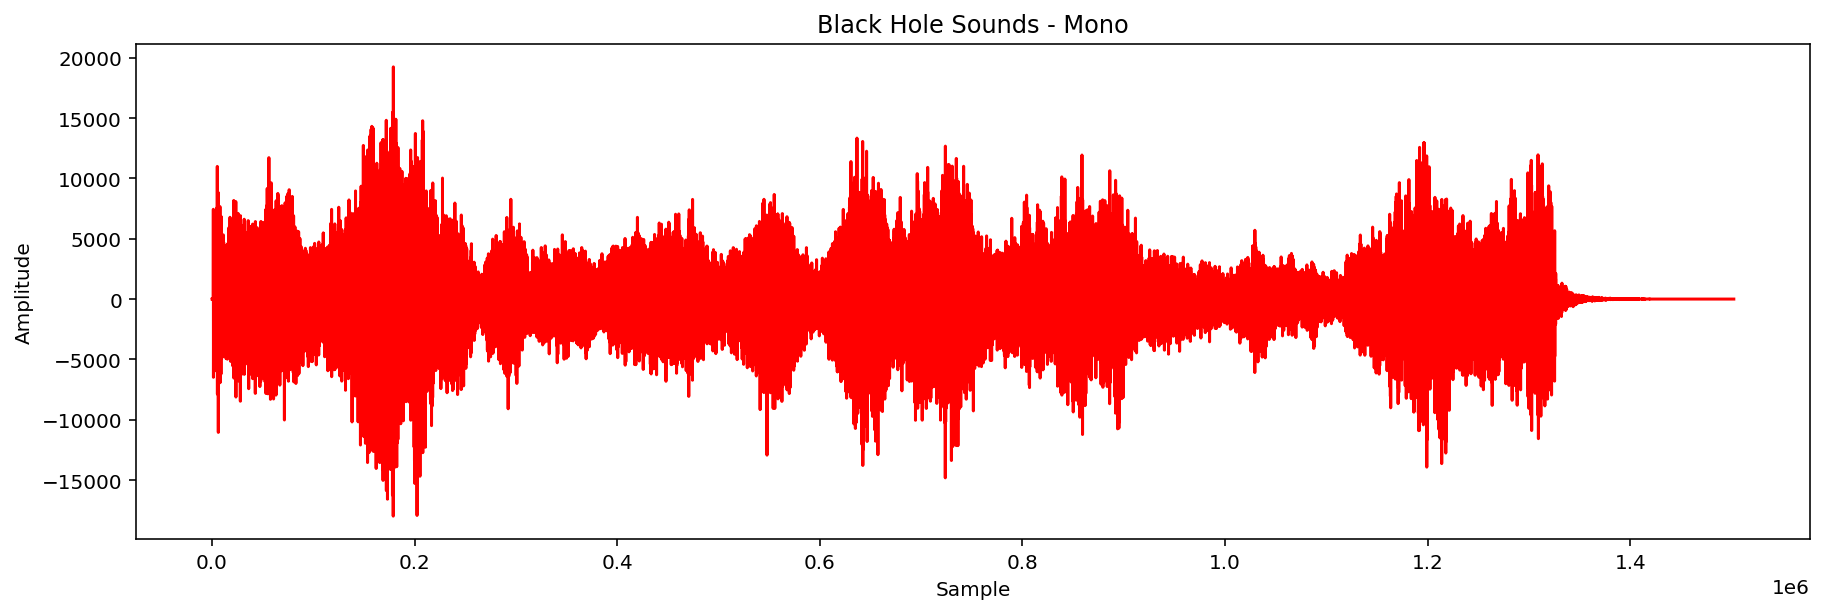

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


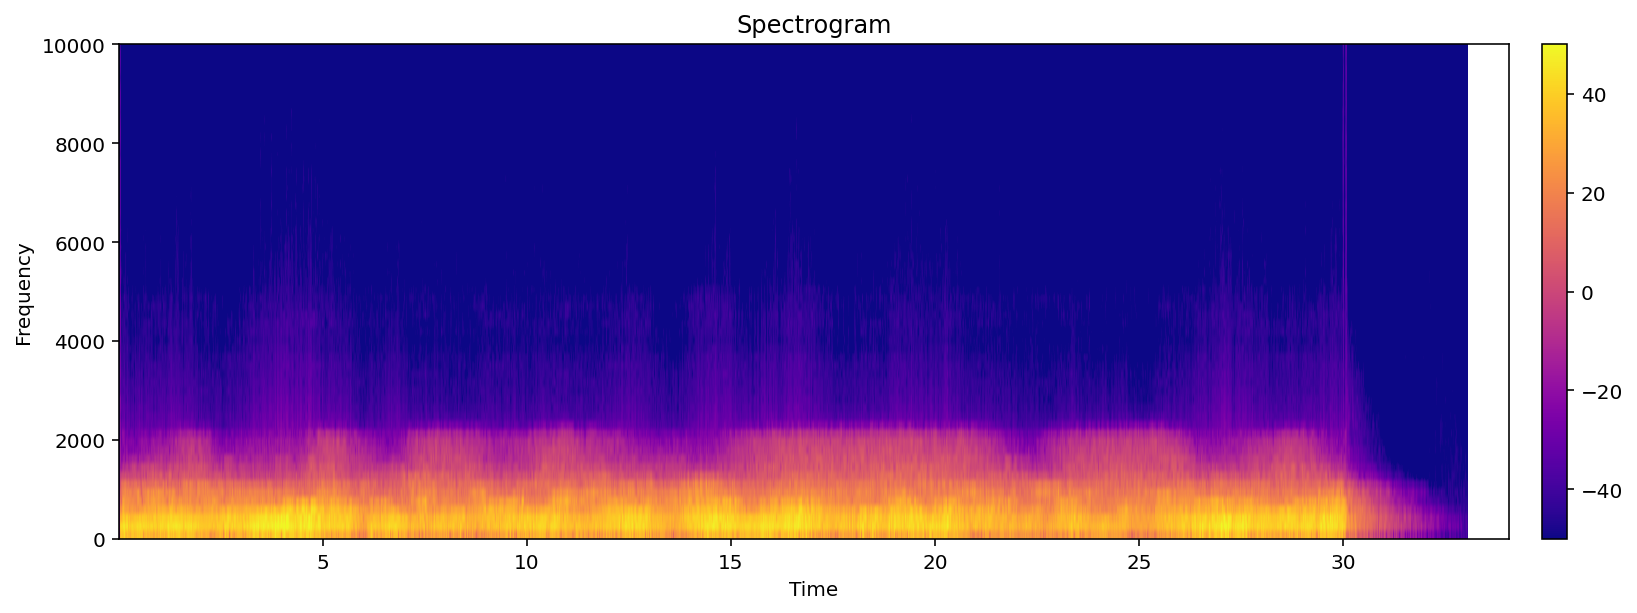

In [24]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.subplot(211)
plt.plot(BHM_data,'r-')
plt.title('Black Hole Sounds - Mono')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.savefig('BH_fig1.jpg')
plt.show()

plt.subplot(212)
plt.specgram(BHM_data, Fs = BHM_rate, cmap='plasma', vmin=-50, vmax=50);
plt.colorbar(pad=0.02)
plt.title('Spectrogram')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.ylim(0,10000)
plt.savefig('BH_fig2.jpg')

plt.show();

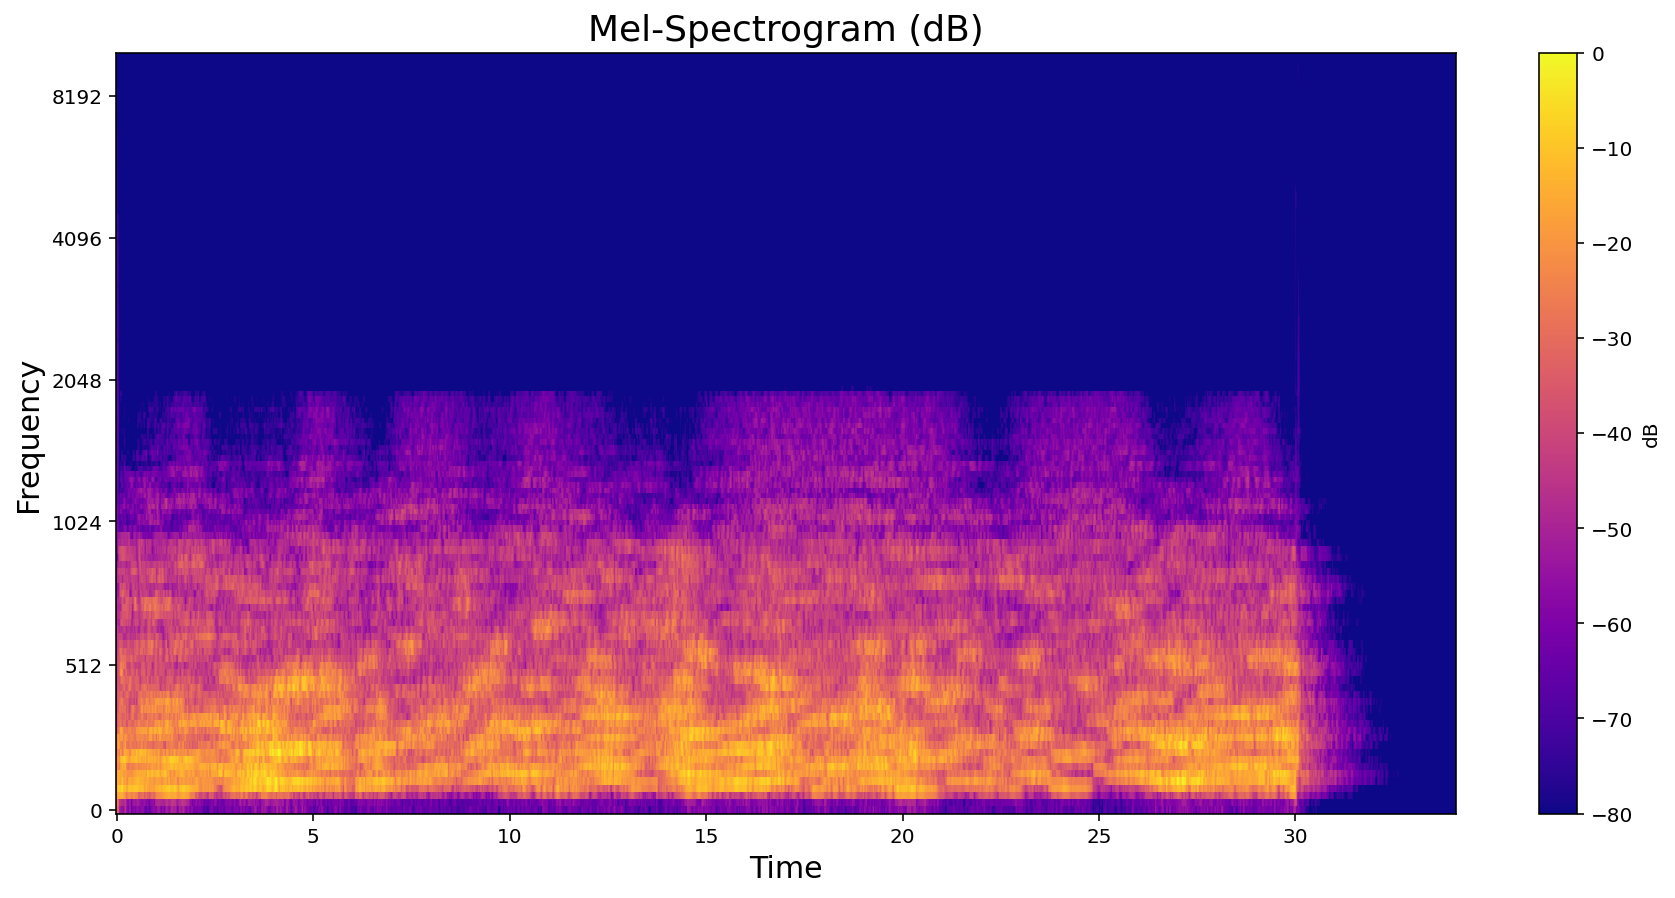

In [25]:
y_bh, sr_bh = librosa.load('bh_perseus_mono.wav')
mel_spec_bh = librosa.feature.melspectrogram(y=y_bh, sr=sr_bh)

#spectrogram = np.abs(mel_spec_light)
s_bh_dB = librosa.power_to_db(mel_spec_bh, ref=np.max)

plt.figure(figsize=(15, 7))
librosa.display.specshow(s_bh_dB, sr=sr_bh, x_axis='time', y_axis='mel', cmap='plasma', 
  hop_length=hop_length, fmax=10000)
plt.colorbar(label='dB')
plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/opt/concourse/worker/volumes/live/d5b9ea1c-8223-4ff6-7416-83e6b4cd6874/volume/ffmpeg_1587154914508/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehol --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilt

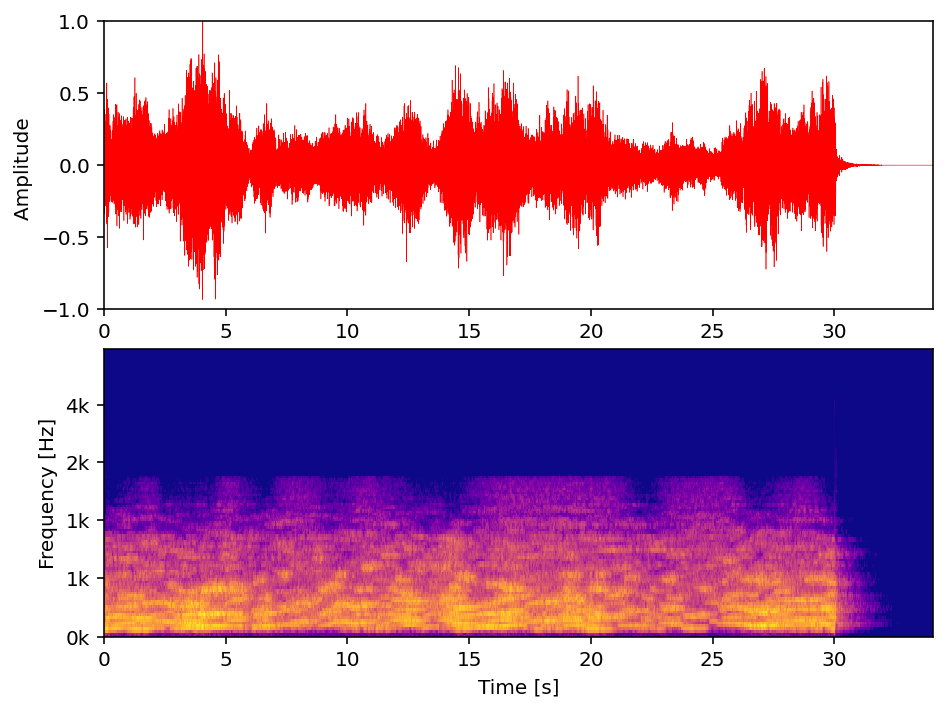

In [27]:
vidwav('bh_perseus_mono.wav')

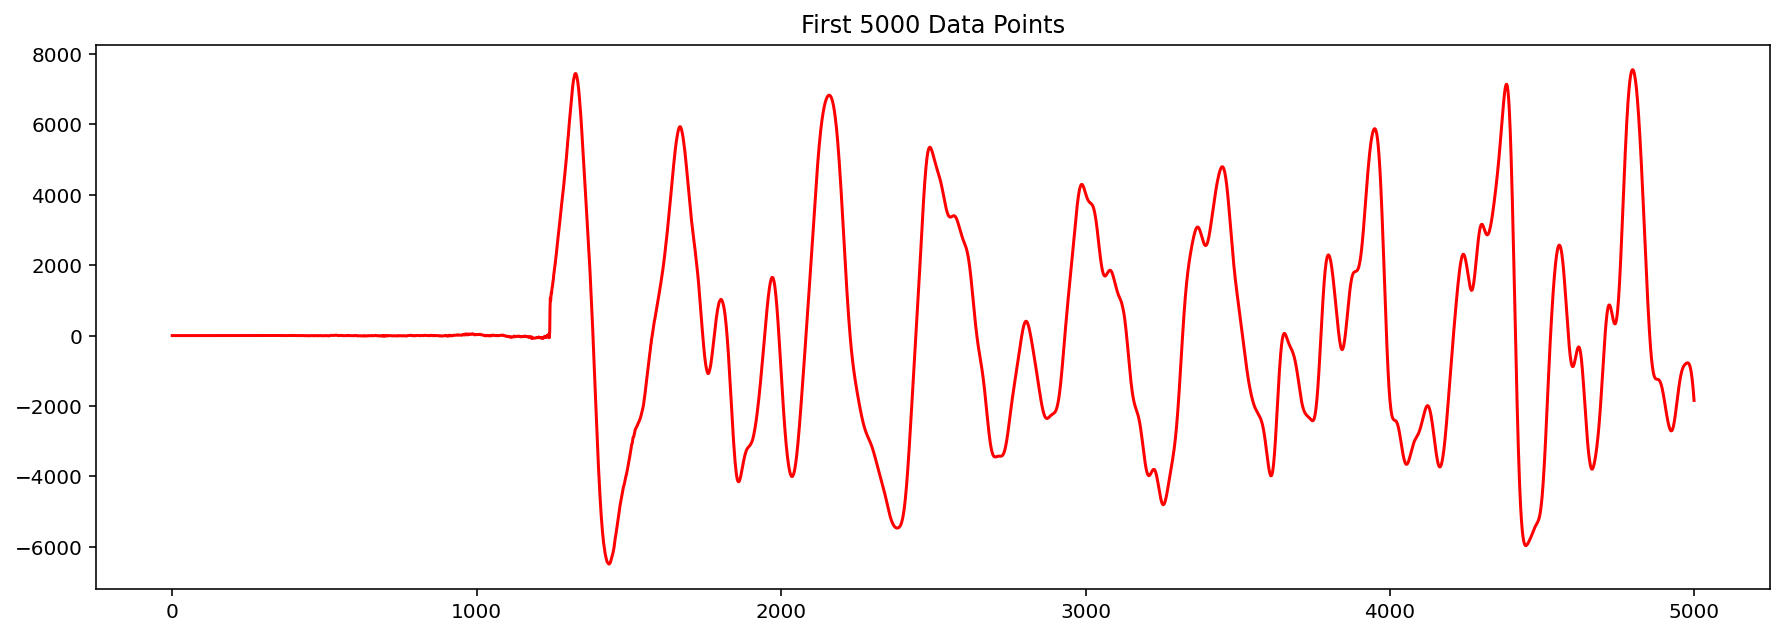

In [28]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(BHM_data[0:5000],'r-')
plt.title('First 5000 Data Points')
plt.show()

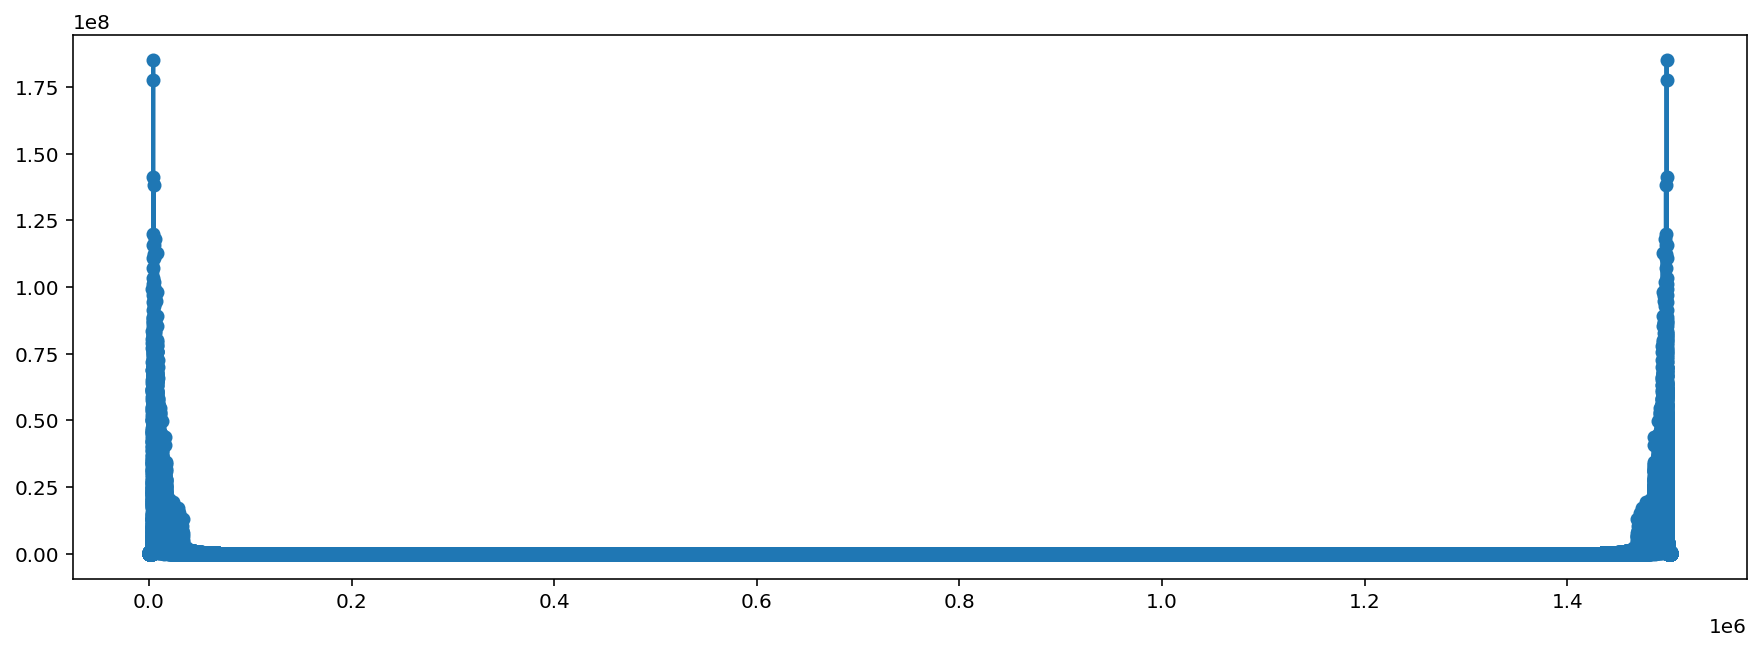

[0.00000000e+00 1.79265028e+11 4.67109042e+10 ... 8.44710017e+04
 7.82998054e+04 3.62531504e+04]


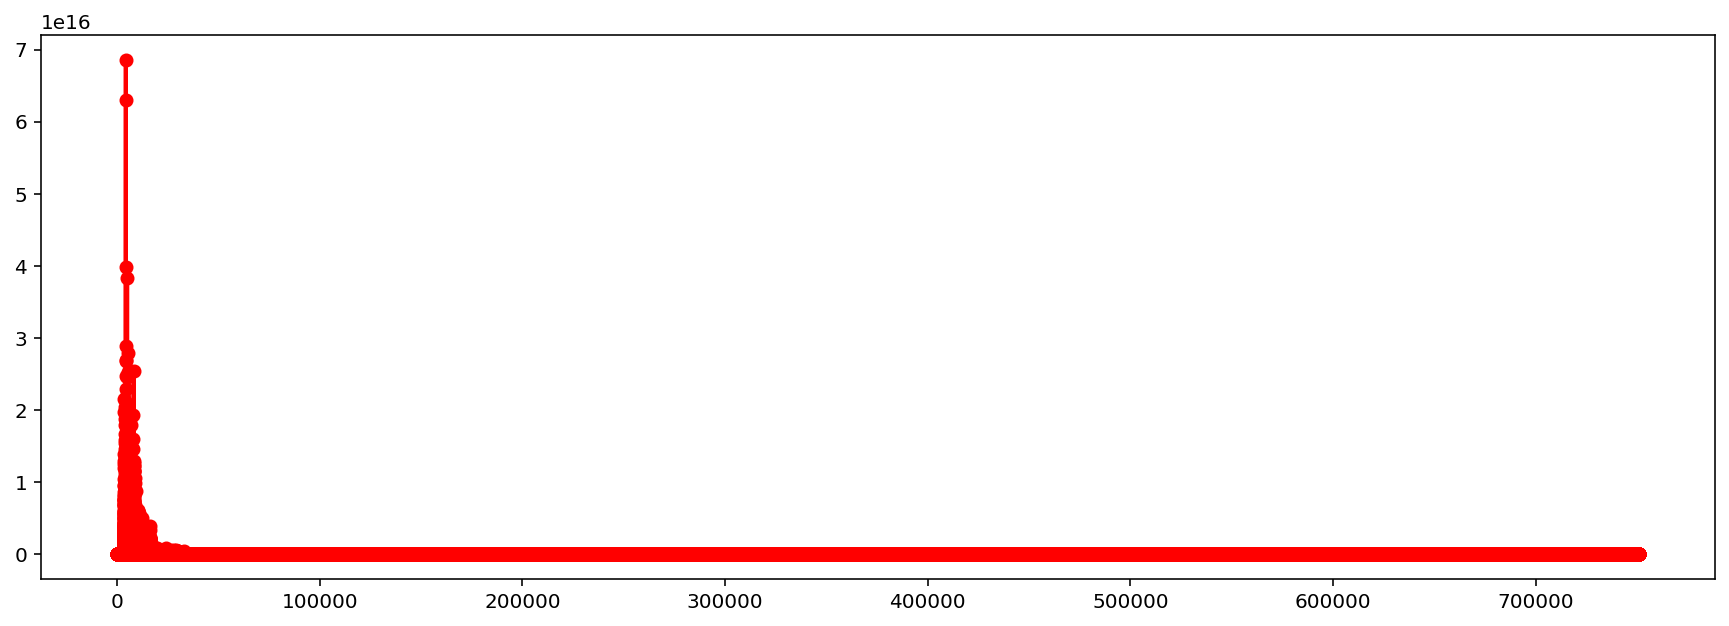

In [29]:
#For FFT, see https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.fft.html
ft = np.fft.fft(BHM_data)
# print(ft)
# print(ft.shape)
nn = ft.shape[0]

#plt.xlim(0,2000)
plt.plot(abs(ft),'o-',lw=2)
plt.show()

fAmp = np.zeros(nn//2)
for i in range(1,nn//2):
    fAmp[i] = abs(ft[i])**2 + abs(ft[nn-i])**2
print(fAmp)

#plt.xlim(800,1600)
plt.plot(fAmp,'ro-',lw=2)
plt.show()

## Interstellar Plasma Sounds

In [30]:
plasma = 'interstellar_plasma_sounds.wav'

wave_obj = sa.WaveObject.from_wave_file(plasma)
play_obj = wave_obj.play()
play_obj.wait_done() 

In [31]:
plasma_rate, plasma_data = wavfile.read(plasma)
print("Data rate [units of Hz = 1/seconds] = ",plasma_rate)
PrintArrayInfo(plasma_data,"data")

Data rate [units of Hz = 1/seconds] =  44100
Array: data
shape: (551808,)
dtype: int16
min, max: -30078 30124



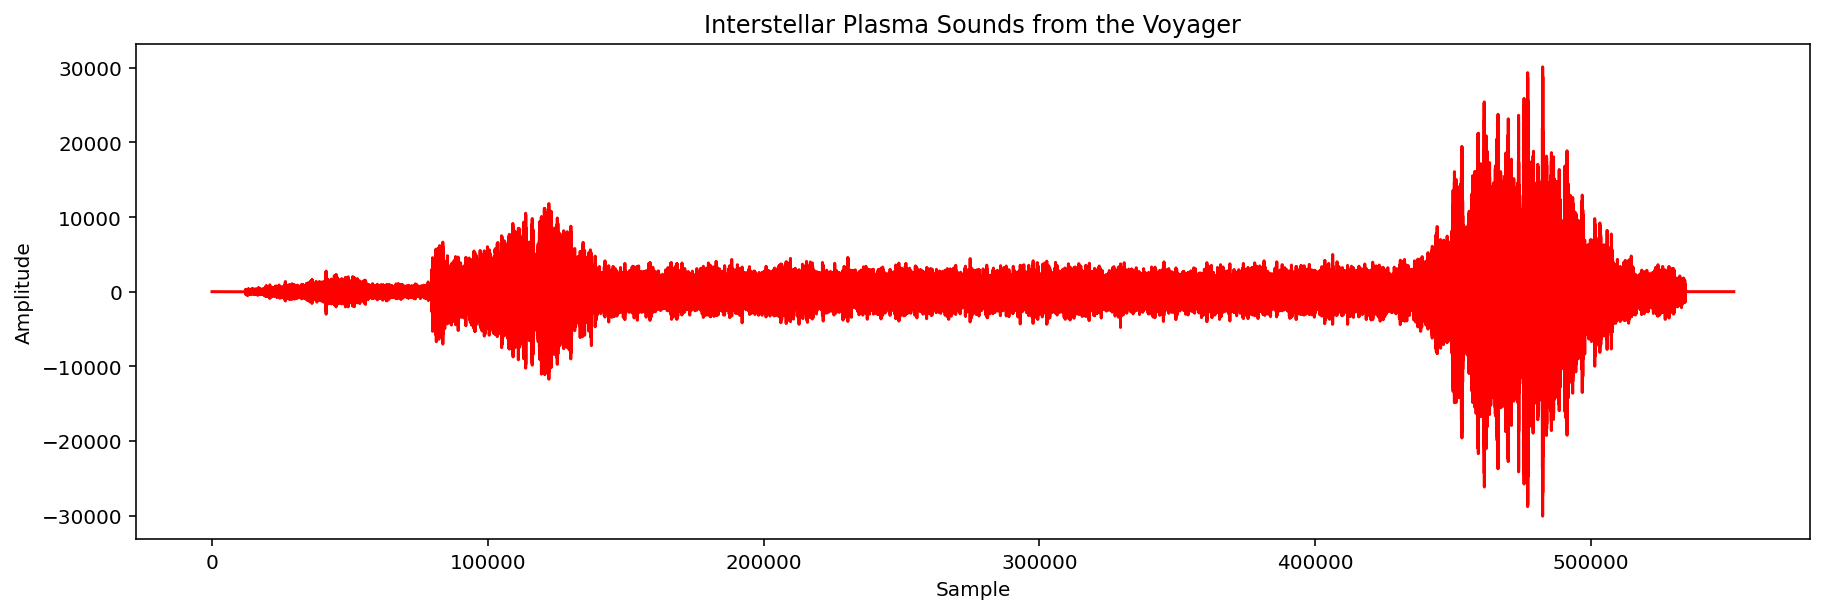

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


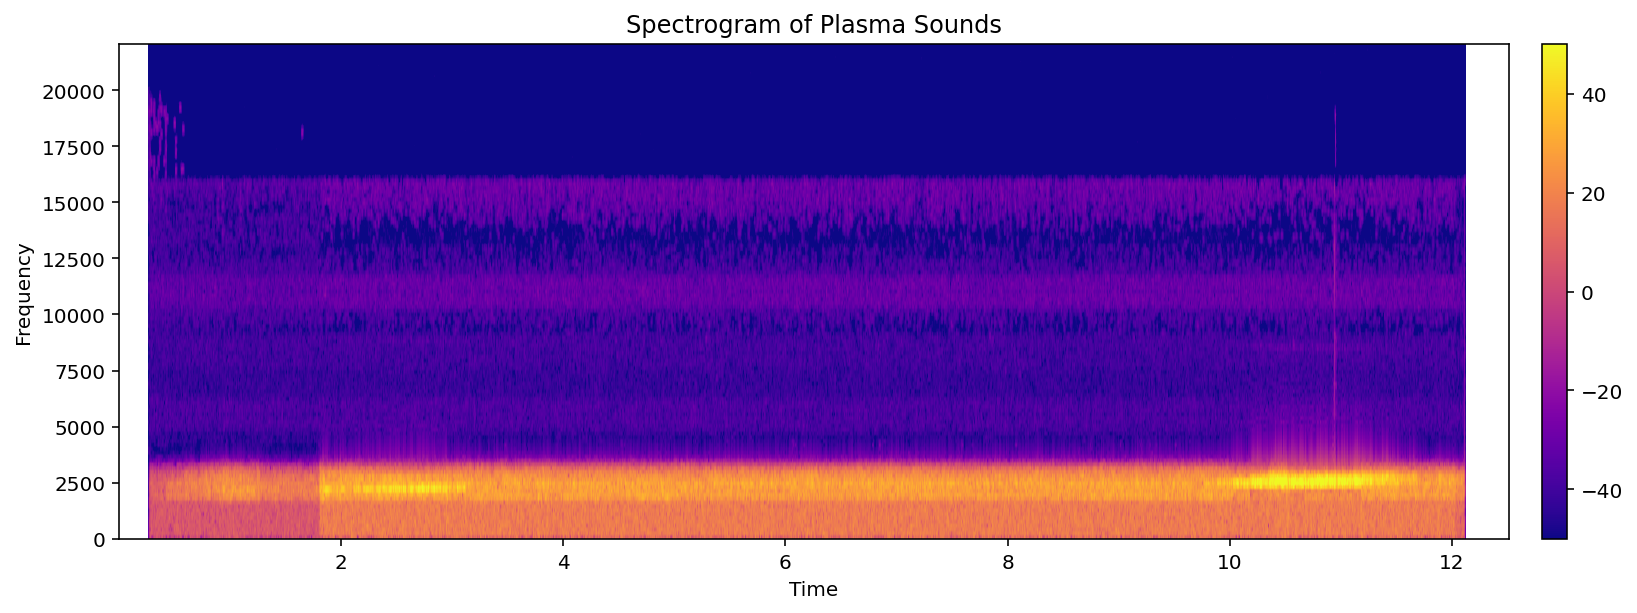

In [32]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.subplot(211)
plt.plot(plasma_data,'r-')
plt.title('Interstellar Plasma Sounds from the Voyager')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.savefig('plasma1.jpg')
plt.show()

plt.subplot(212)
plt.specgram(plasma_data, Fs = plasma_rate, cmap='plasma', vmin=-50, vmax=50);
plt.colorbar(pad=0.02)
plt.title('Spectrogram of Plasma Sounds')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.savefig('plasma2.jpg')
plt.show();

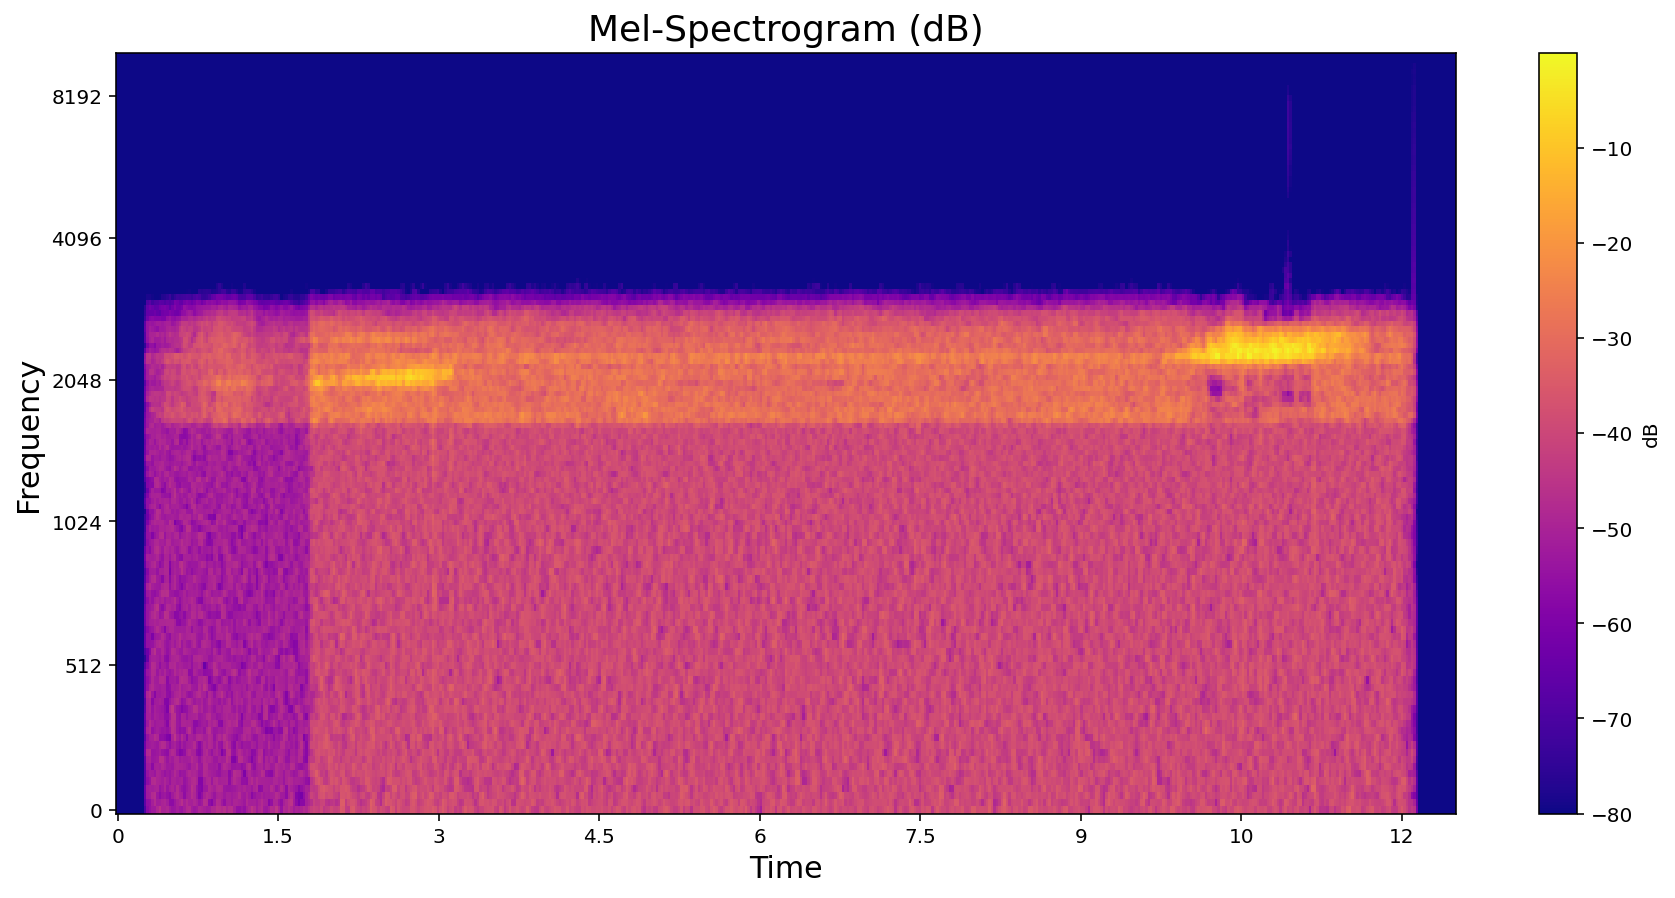

In [33]:
y_plasma, sr_plasma = librosa.load('interstellar_plasma_sounds.wav')
mel_spec_plasma = librosa.feature.melspectrogram(y=y_plasma, sr=sr_plasma)

#spectrogram = np.abs(mel_spec_light)
s_plasma_dB = librosa.power_to_db(mel_spec_plasma, ref=np.max)

plt.figure(figsize=(15, 7))
librosa.display.specshow(s_plasma_dB, sr=sr_plasma, x_axis='time', y_axis='mel', cmap='plasma', 
  hop_length=hop_length, fmax=10000)
plt.colorbar(label='dB')
plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

(551808,)


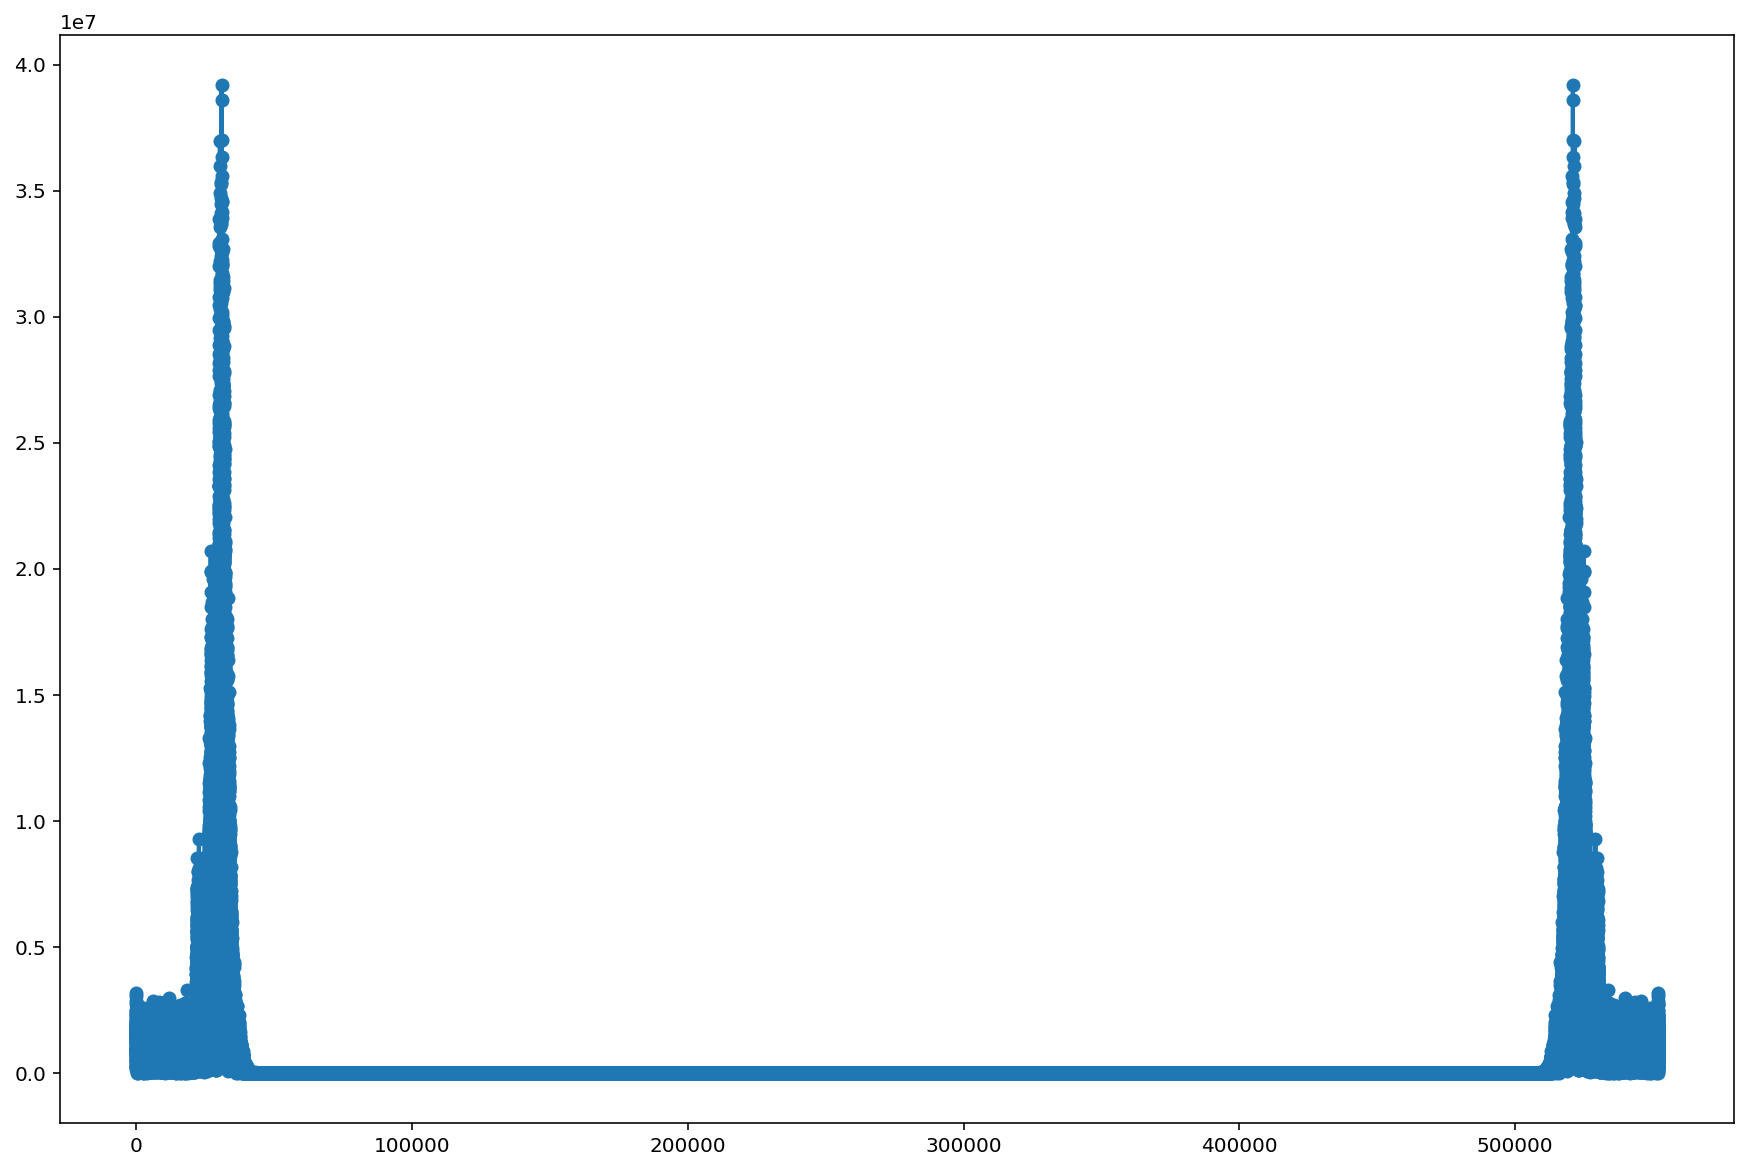

[0.00000000e+00 8.46361740e+12 3.45265214e+12 ... 2.01543750e+05
 5.37136295e+04 8.18650947e+04]


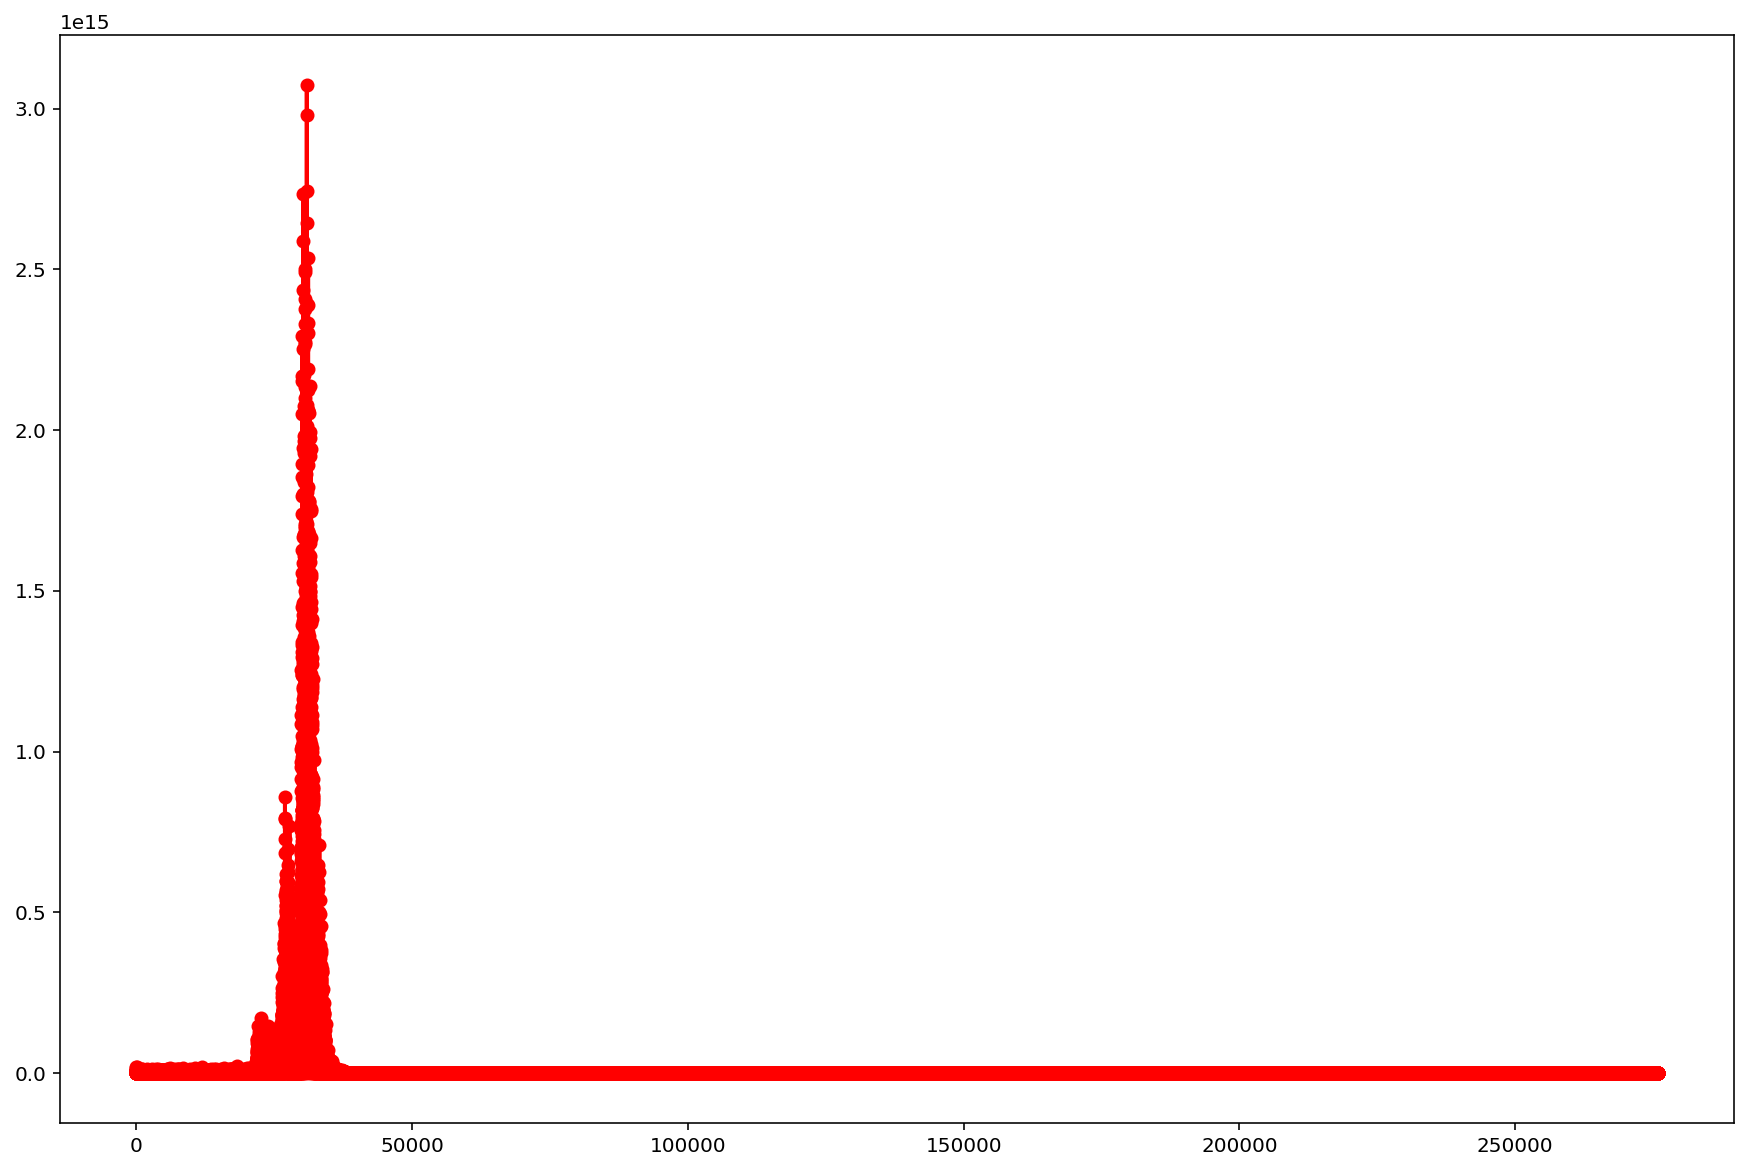

In [34]:
ft_plasma = np.fft.fft(plasma_data)
# print(ft)
print(ft_plasma.shape)
nn = ft_plasma.shape[0]

#plt.xlim(0,2000)
plt.plot(abs(ft_plasma),'o-',lw=2)
plt.show()

fAmp_plasma = np.zeros(nn//2)
for i in range(1,nn//2):
    fAmp_plasma[i] = abs(ft_plasma[i])**2 + abs(ft_plasma[nn-i])**2
print(fAmp_plasma)

#plt.xlim(800,1600)
plt.plot(fAmp_plasma,'ro-',lw=2)
plt.show()

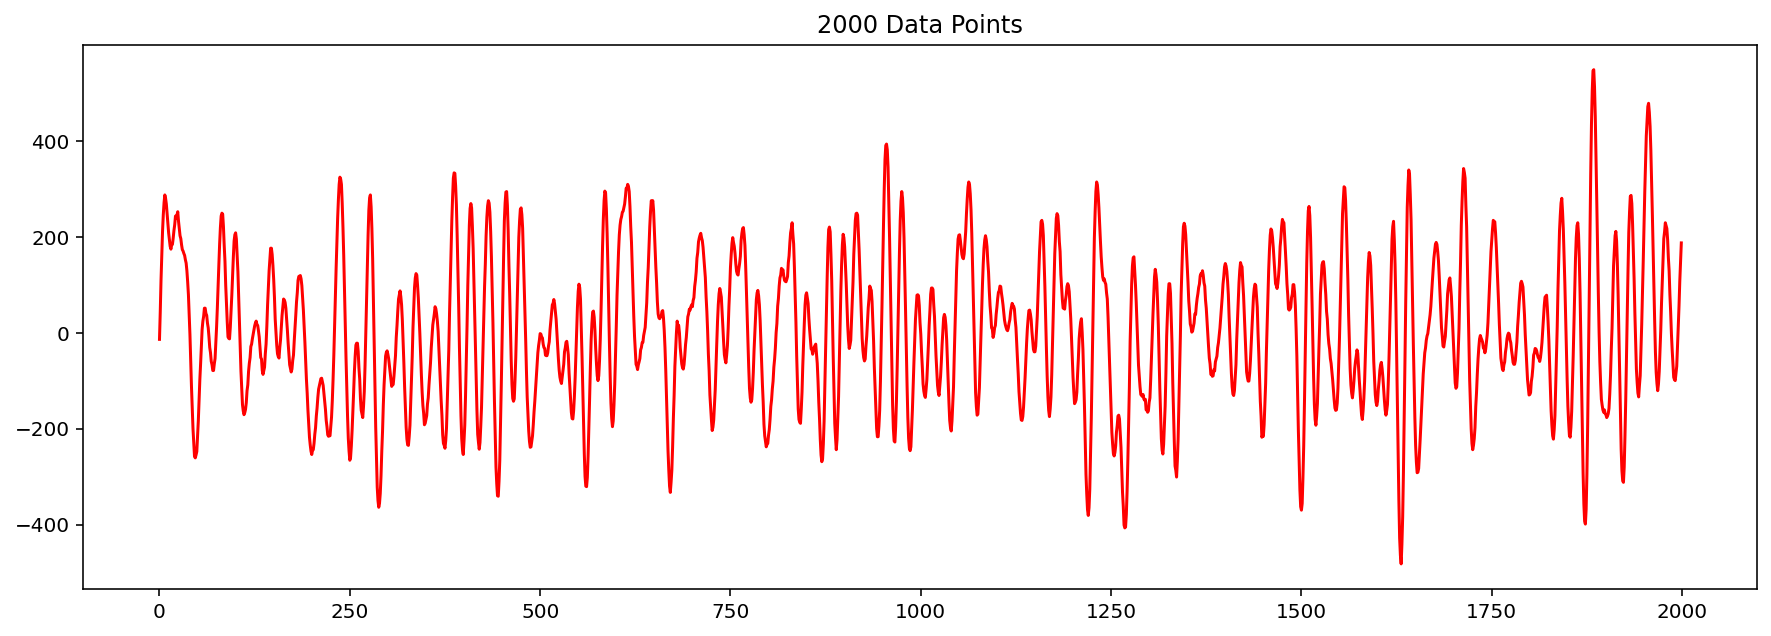

In [35]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(plasma_data[15000:17000],'r-')
plt.title('2000 Data Points')
plt.show()

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/opt/concourse/worker/volumes/live/d5b9ea1c-8223-4ff6-7416-83e6b4cd6874/volume/ffmpeg_1587154914508/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehol --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilt

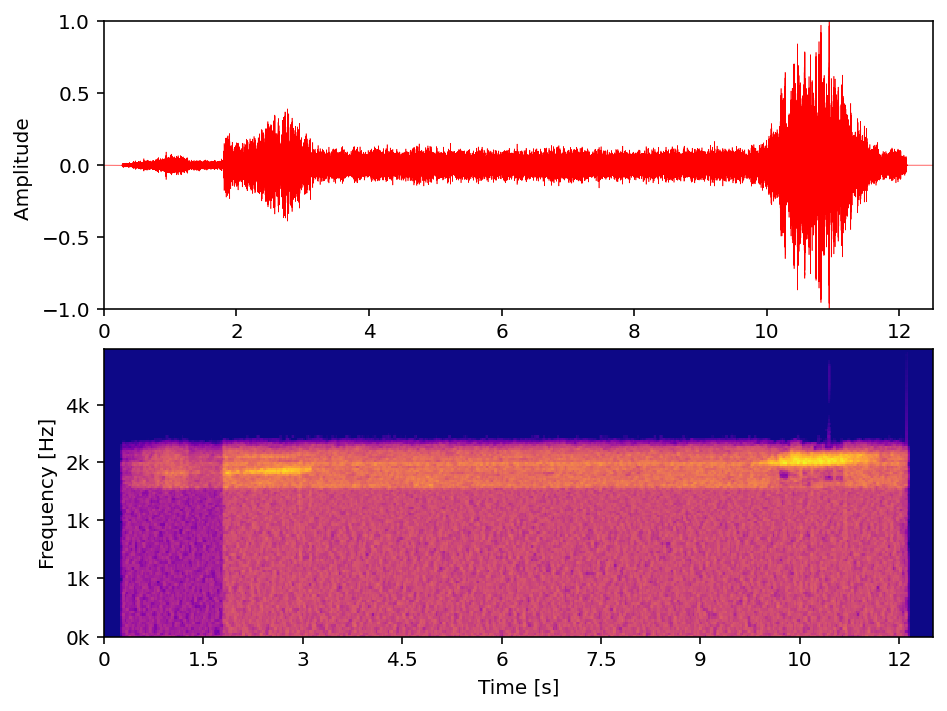

In [36]:
vidwav('interstellar_plasma_sounds.wav')

## Juno: Entering Jupiter's Magnetosphere

In [37]:
ms = 'magnetosphere.wav'

wave_obj = sa.WaveObject.from_wave_file(ms)
play_obj = wave_obj.play()
play_obj.wait_done() 

In [38]:
ms_rate, ms_data = wavfile.read(ms)
print("Data rate [units of Hz = 1/seconds] = ",ms_rate)
PrintArrayInfo(ms_data,"data")

Data rate [units of Hz = 1/seconds] =  44100
Array: data
shape: (728067, 2)
dtype: int16
min, max: -23432 22501



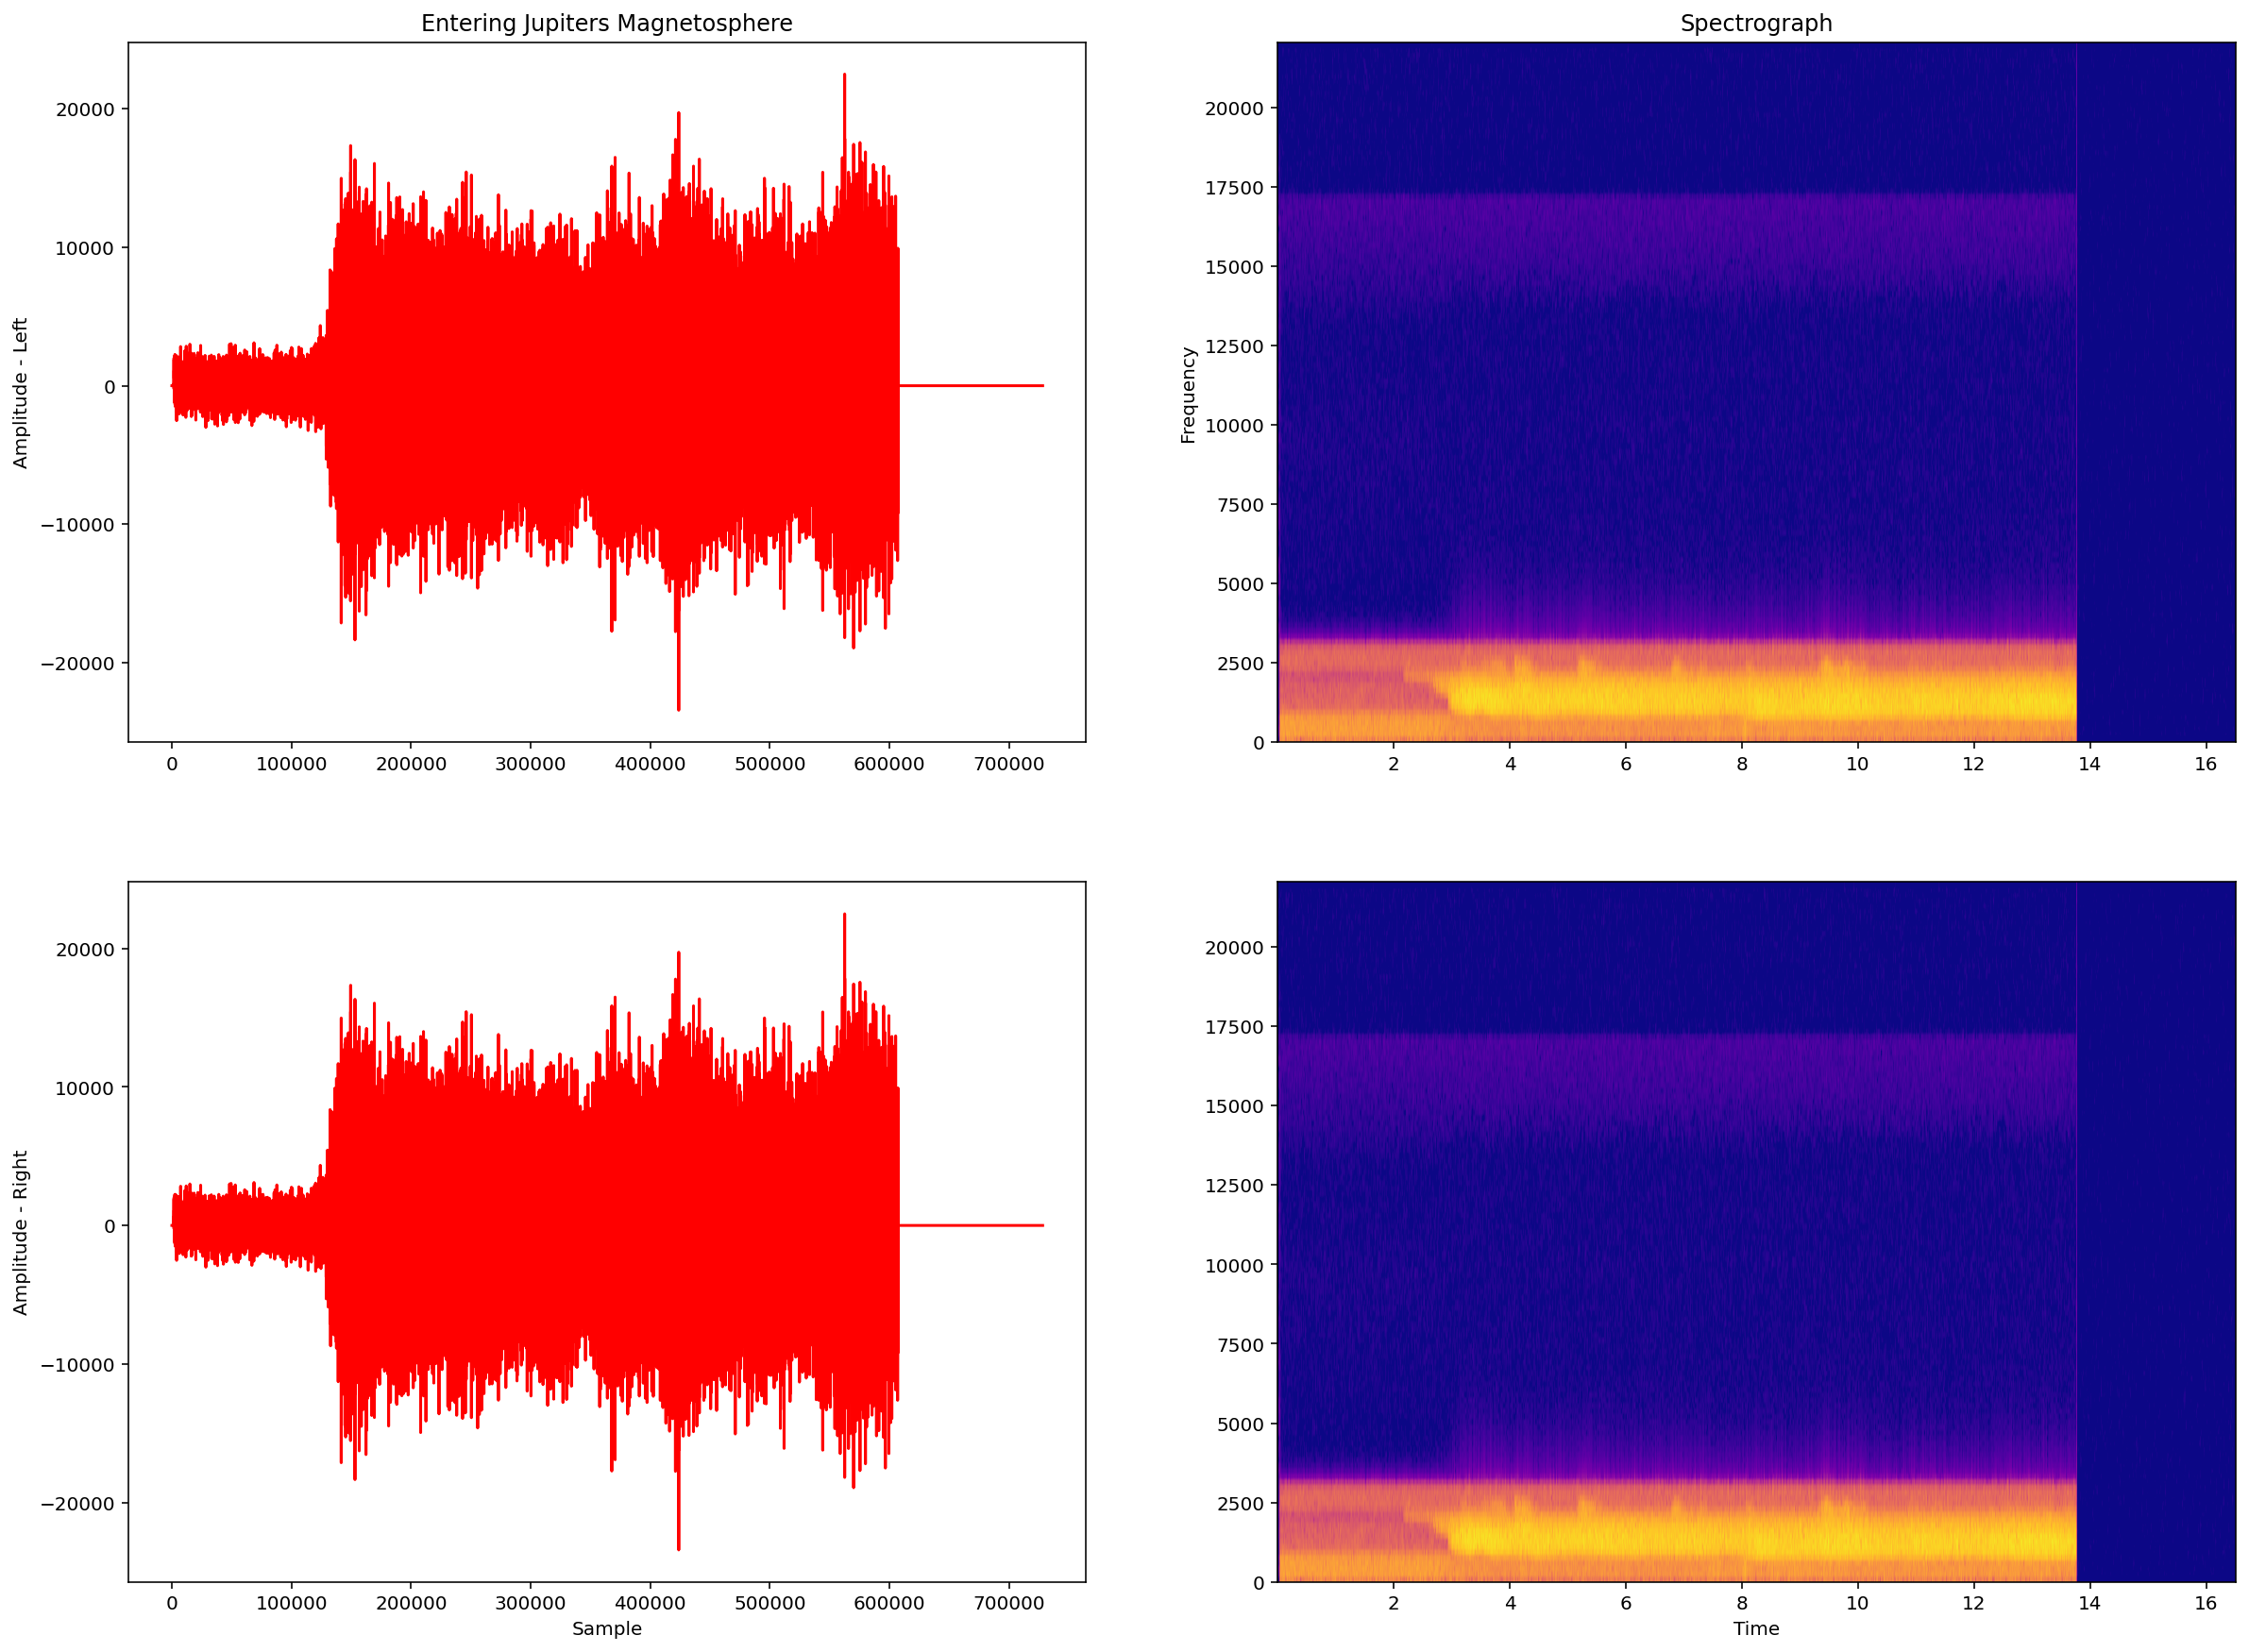

In [39]:
plt.rcParams['figure.figsize'] = [20, 15]

fig, axs = plt.subplots(2, 2)

axs[0,0].plot(ms_data[:,0],'r-')
axs[0,0].set_title('Entering Jupiters Magnetosphere')
axs[0,0].set_ylabel('Amplitude - Left')

axs[0,1].specgram(ms_data[:,0], Fs = ms_rate, cmap='plasma',vmin=-50, vmax=50)
#axs[0,0].colorbar()
axs[0,1].set_title('Spectrograph')
axs[0,1].set_ylabel('Frequency')
#axs[0,1].set_ylim(0,10000)

axs[1,0].plot(ms_data[:,1],'r-')
axs[1,0].set_xlabel('Sample')
axs[1,0].set_ylabel('Amplitude - Right')

axs[1,1].specgram(ms_data[:,1], Fs = ms_rate, cmap='plasma',vmin=-50, vmax=50)
#plt.colorbar()
axs[1,1].set_xlabel('Time')
#axs[1,1].set_ylim(0,10000)

plt.show()

In [40]:
# combined sound
sound = AudioSegment.from_wav(ms)
sound = sound.set_channels(1)
ms_mono = ms[:-4]+'_mono.wav'
sound.export(ms_mono,format="wav")

<_io.BufferedRandom name='magnetosphere_mono.wav'>

In [41]:
msm_rate, msm_data = wavfile.read(ms_mono)
print("Data rate [units of Hz = 1/seconds] = ",msm_rate)
PrintArrayInfo(msm_data,"data")

Data rate [units of Hz = 1/seconds] =  44100
Array: data
shape: (728067,)
dtype: int16
min, max: -23432 22500



In [42]:
wave_obj = sa.WaveObject.from_wave_file(ms_mono)
play_obj = wave_obj.play()
play_obj.wait_done() 

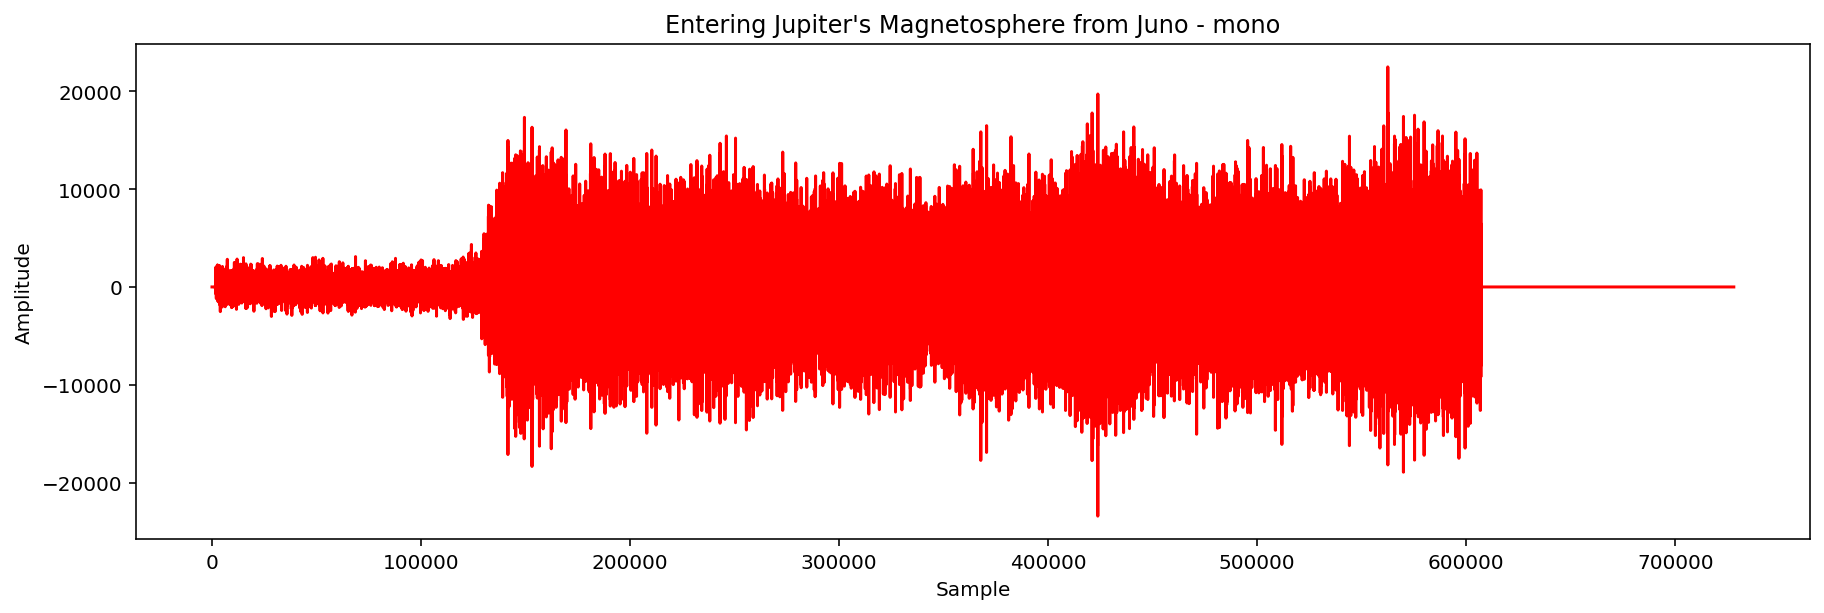

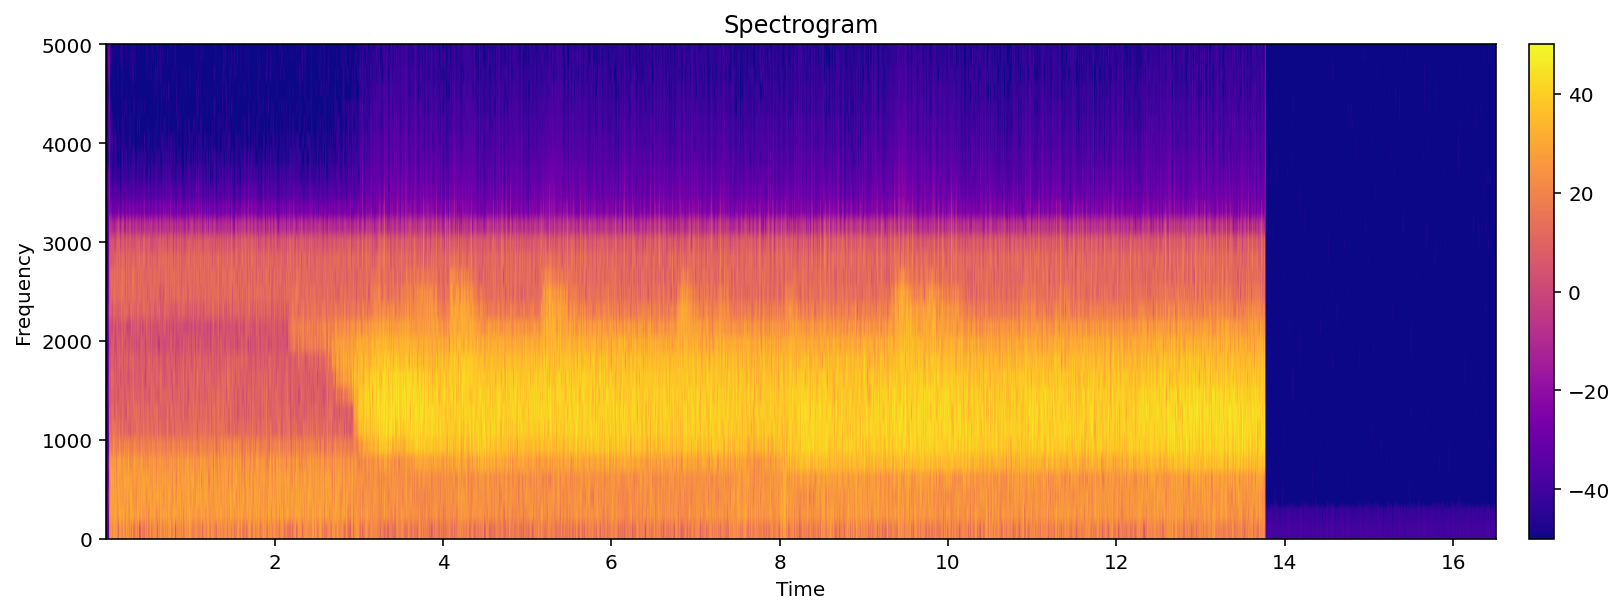

In [43]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.subplot(211)
plt.plot(msm_data,'r-')
plt.title("Entering Jupiter's Magnetosphere from Juno - mono")
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.savefig('ms1.jpg')
plt.show()

plt.subplot(212)
plt.specgram(msm_data, Fs = msm_rate, cmap='plasma', vmin=-50, vmax=50);
plt.colorbar(pad=0.02)
plt.title('Spectrogram')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.savefig('ms2.jpg')
plt.ylim(0,5000)
plt.show()

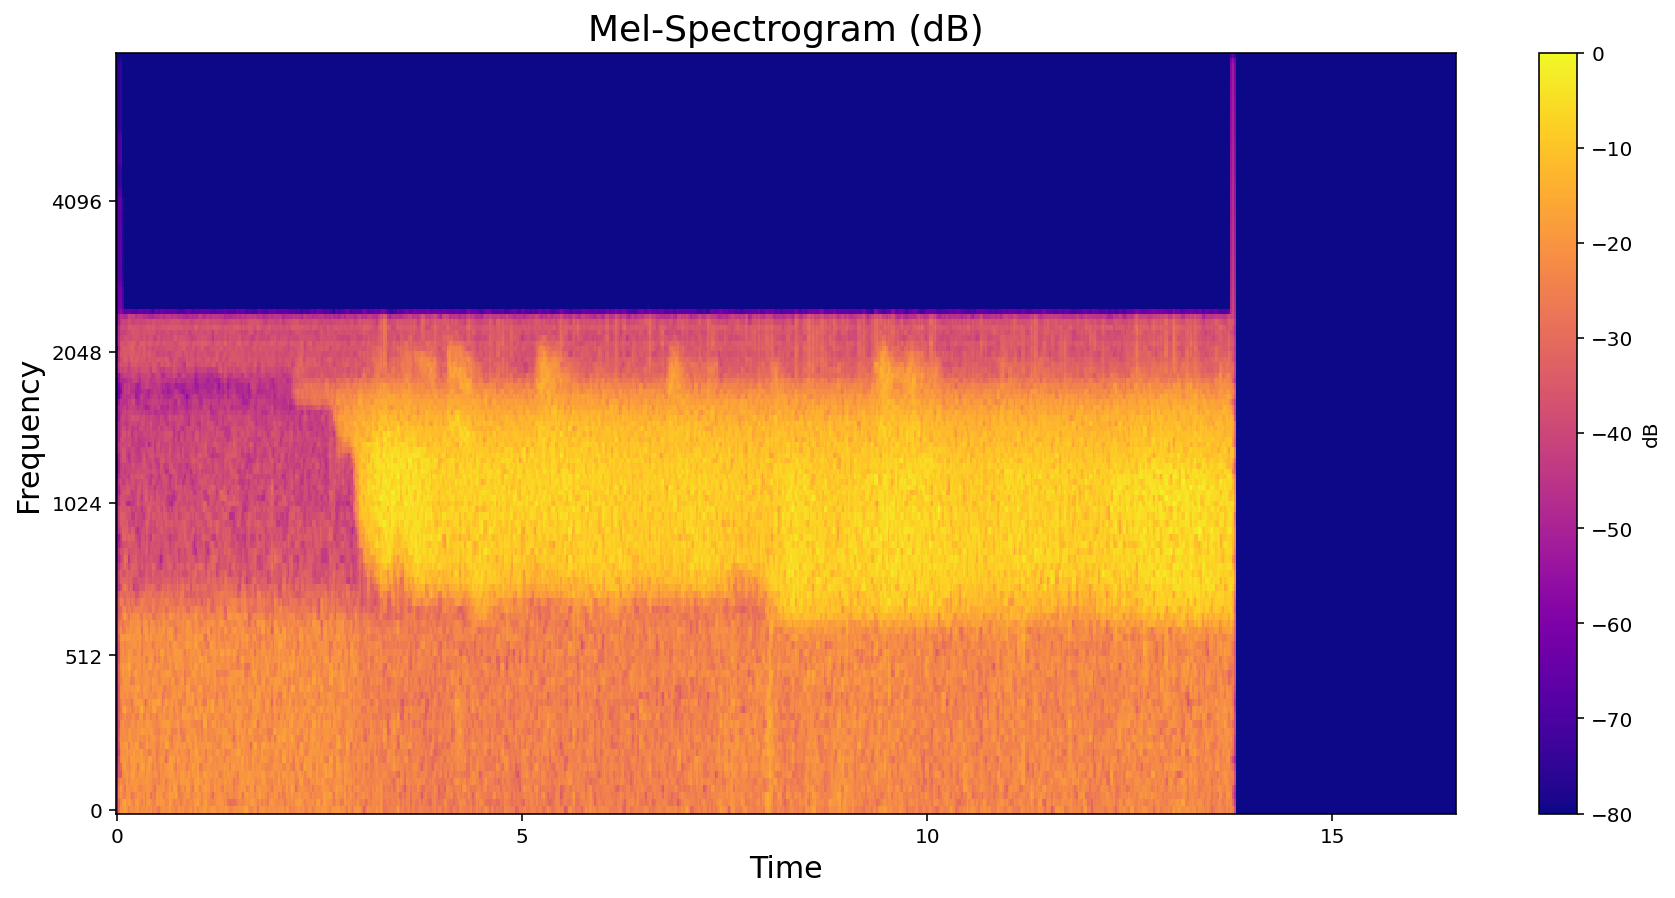

In [44]:
y_ms, sr_ms = librosa.load('magnetosphere_mono.wav')
mel_spec_ms = librosa.feature.melspectrogram(y=y_ms, sr=sr_ms)

#spectrogram = np.abs(mel_spec_light)
s_ms_dB = librosa.power_to_db(mel_spec_ms, ref=np.max)

plt.figure(figsize=(15, 7))
librosa.display.specshow(s_ms_dB, sr=sr_ms, x_axis='time', y_axis='mel', cmap='plasma', 
  hop_length=hop_length, fmax=8000)
plt.colorbar(label='dB')
plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/opt/concourse/worker/volumes/live/d5b9ea1c-8223-4ff6-7416-83e6b4cd6874/volume/ffmpeg_1587154914508/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehol --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilt

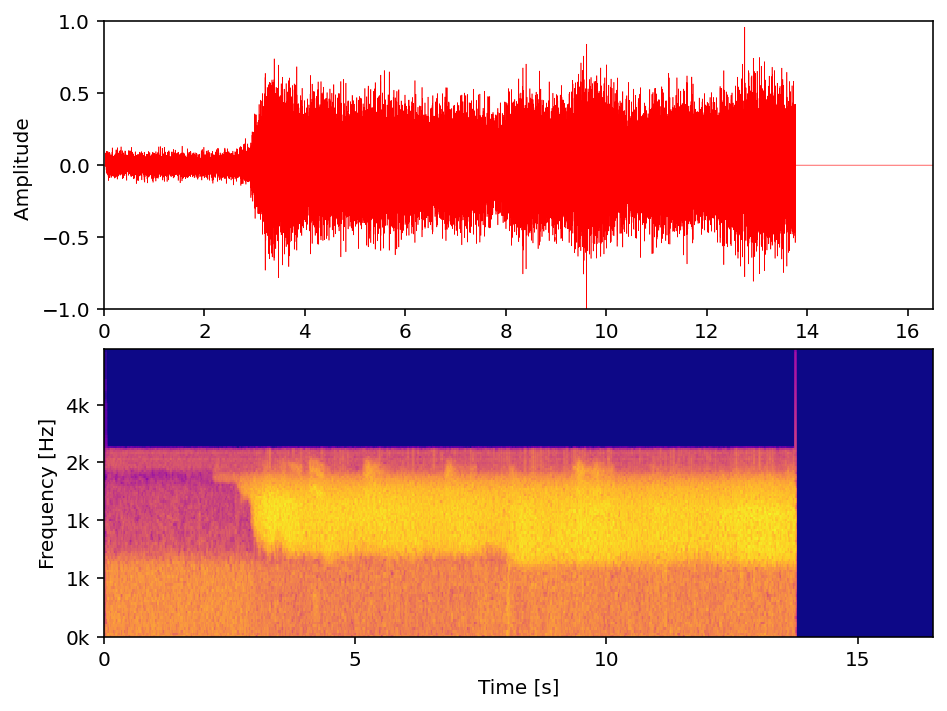

In [45]:
vidwav('magnetosphere_mono.wav')

(728067,)


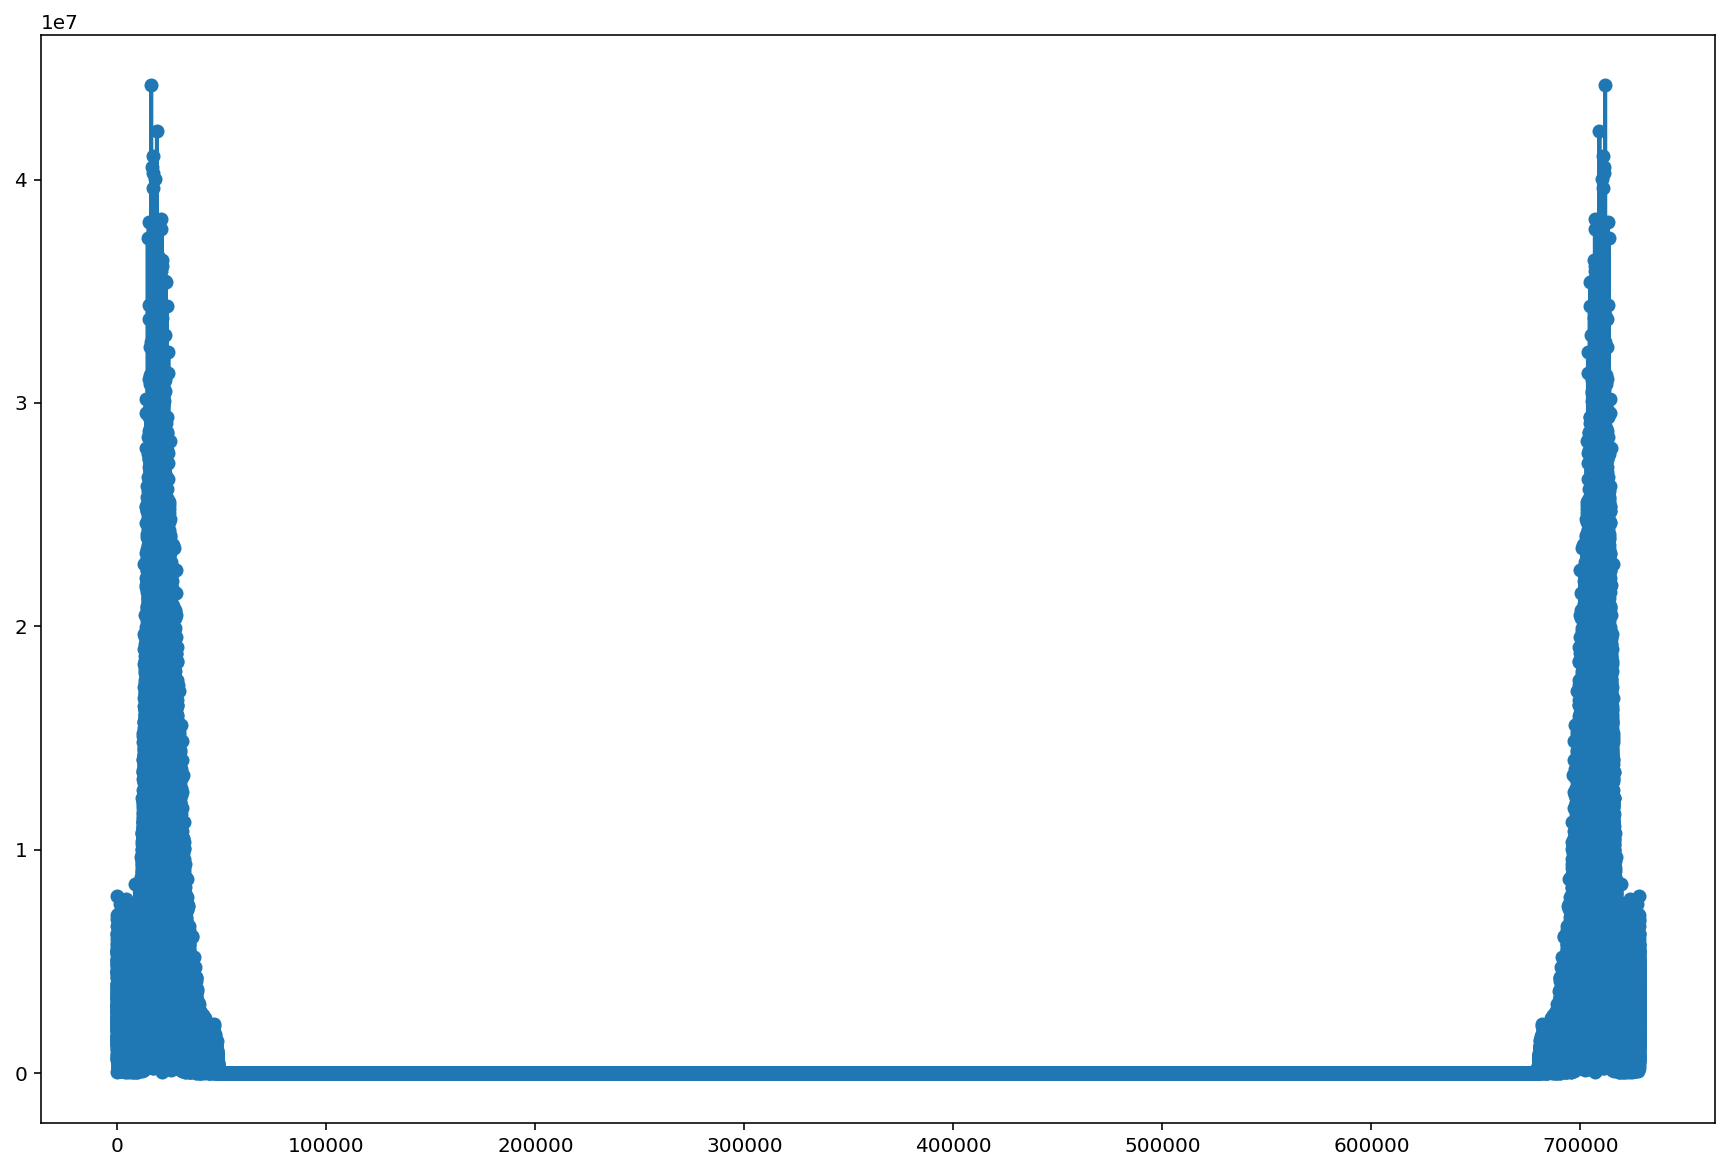

[0.00000000e+00 4.22720341e+13 7.69255191e+13 ... 1.96861065e+07
 1.28379293e+07 1.69671545e+07]


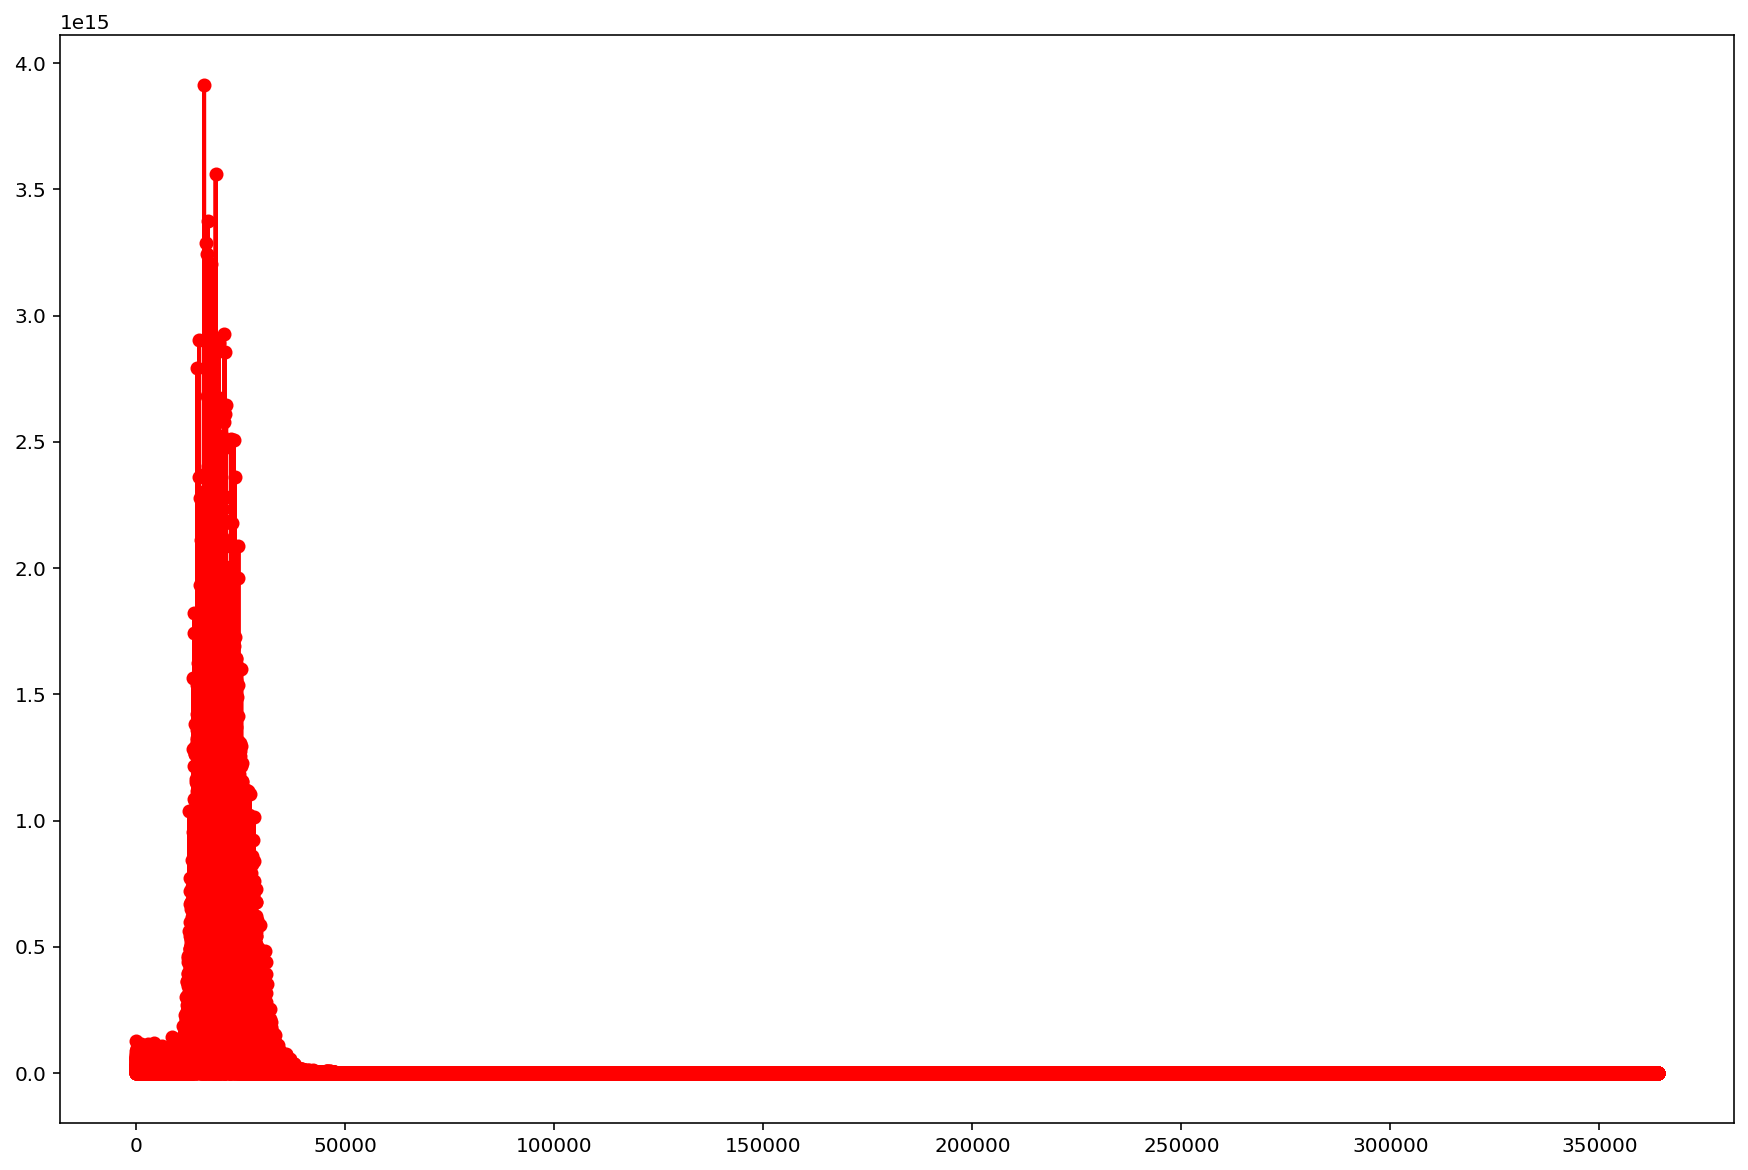

In [46]:
ft_ms_mono = np.fft.fft(msm_data)
# print(ft)
print(ft_ms_mono.shape)
nn = ft_ms_mono.shape[0]

#plt.xlim(0,2000)
plt.plot(abs(ft_ms_mono),'o-',lw=2)
plt.show()

fAmp_ms_mono = np.zeros(nn//2)
for i in range(1,nn//2):
    fAmp_ms_mono[i] = abs(ft_ms_mono[i])**2 + abs(ft_ms_mono[nn-i])**2
print(fAmp_ms_mono)

#plt.xlim(800,1600)
plt.plot(fAmp_ms_mono,'ro-',lw=2)
plt.show()

## Voyager: Lightning on Jupiter

In [47]:
light = 'jupiter_lightning.wav'

# wave_obj = sa.WaveObject.from_wave_file(light)
# play_obj = wave_obj.play()
# play_obj.wait_done() 

In [48]:
light_rate, light_data = wavfile.read(light)
print("Data rate [units of Hz = 1/seconds] = ",light_rate)
PrintArrayInfo(light_data,"data")

Data rate [units of Hz = 1/seconds] =  11025
Array: data
shape: (86214,)
dtype: int16
min, max: -24321 28056



In [49]:
len(light_data)/light_rate

7.8198639455782315

In [50]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

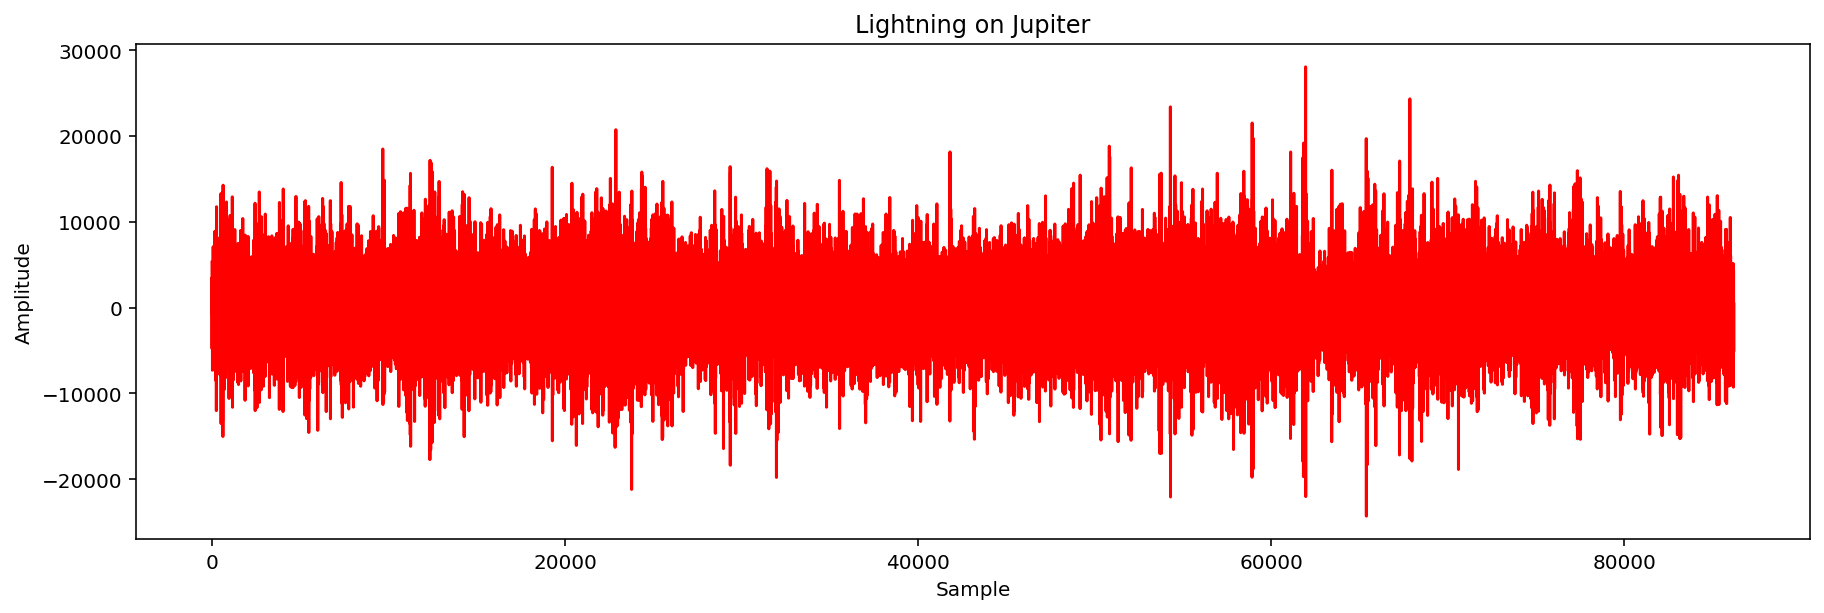

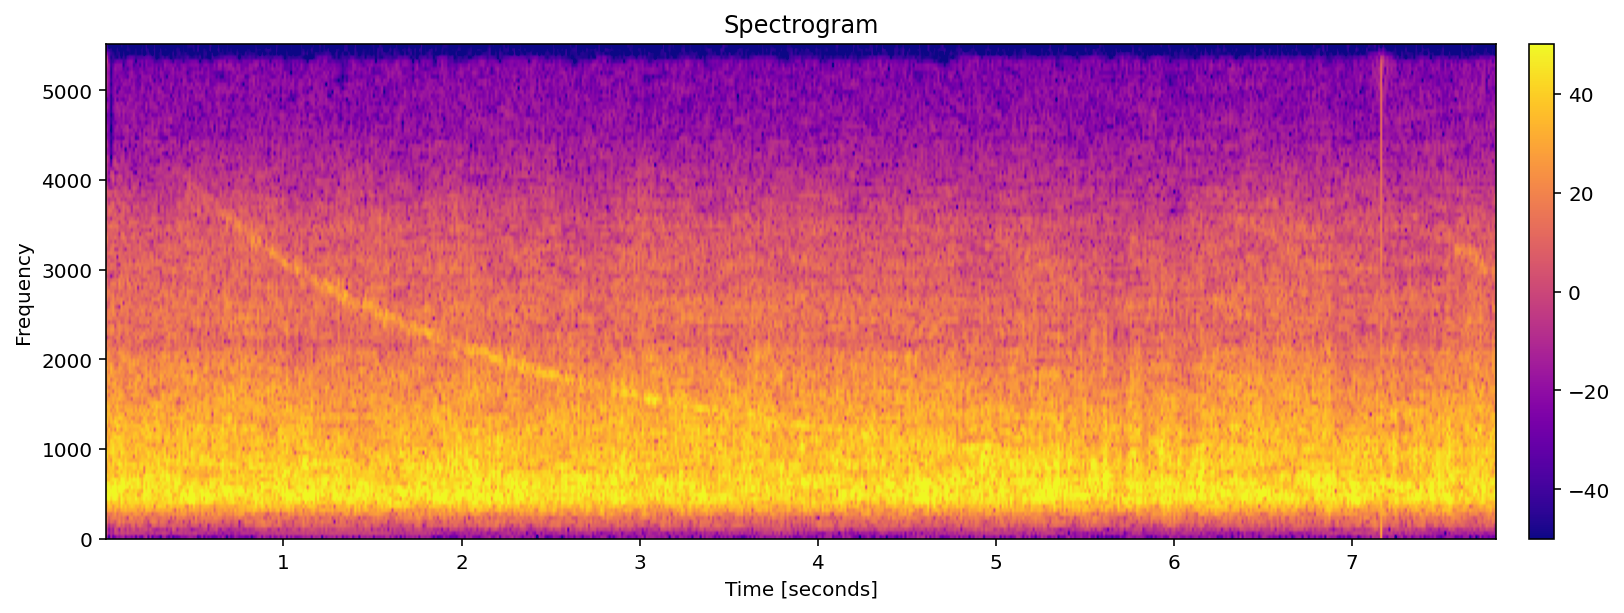

In [51]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.subplot(211)
plt.plot(light_data,'r-')
plt.title("Lightning on Jupiter")
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.savefig('lightning1.jpg')
plt.show()

plt.subplot(212)
plt.specgram(light_data, Fs = light_rate, cmap='plasma', vmin=-50, vmax=50);
plt.title('Spectrogram')
plt.ylabel('Frequency')
plt.xlabel('Time [seconds]')
plt.colorbar(pad = .02)
plt.savefig('lightning2.jpg')
plt.show()

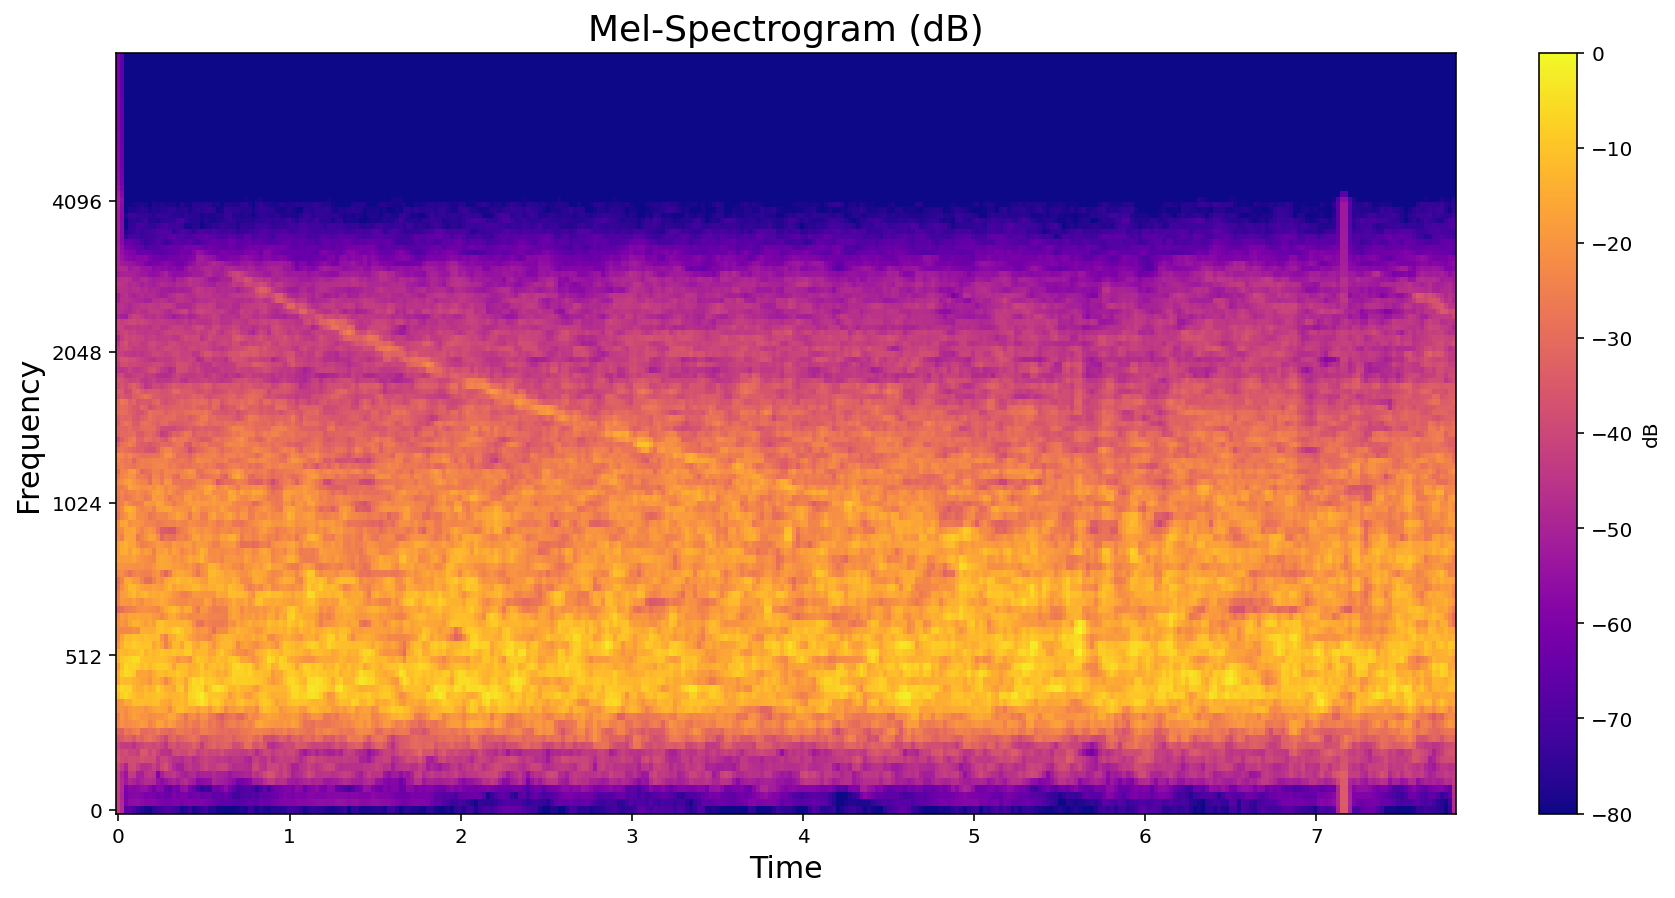

In [52]:
y_light, sr_light = librosa.load('jupiter_lightning.wav')
mel_spec_light = librosa.feature.melspectrogram(y=y_light, sr=sr_light)

#spectrogram = np.abs(mel_spec_light)
s_light_dB = librosa.power_to_db(mel_spec_light, ref=np.max)

plt.figure(figsize=(15, 7))
librosa.display.specshow(s_light_dB, sr=sr_light, x_axis='time', y_axis='mel', cmap='plasma', 
  hop_length=hop_length, fmax=8000)
plt.colorbar(label='dB')
plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/opt/concourse/worker/volumes/live/d5b9ea1c-8223-4ff6-7416-83e6b4cd6874/volume/ffmpeg_1587154914508/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehol --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilt

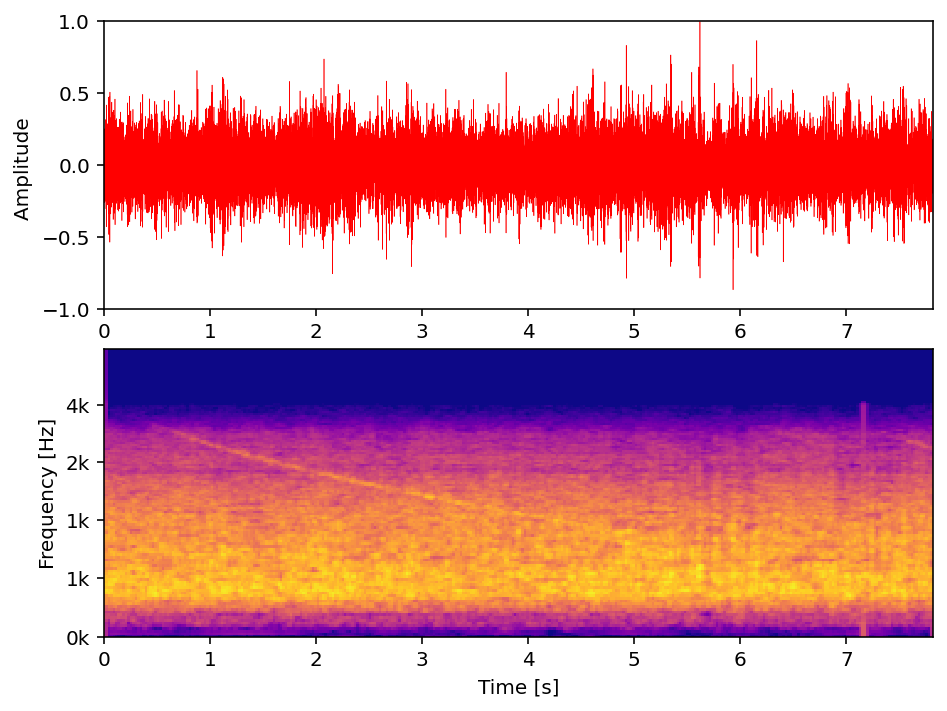

In [53]:
vidwav('jupiter_lightning.wav')

## FFT

(86214,)


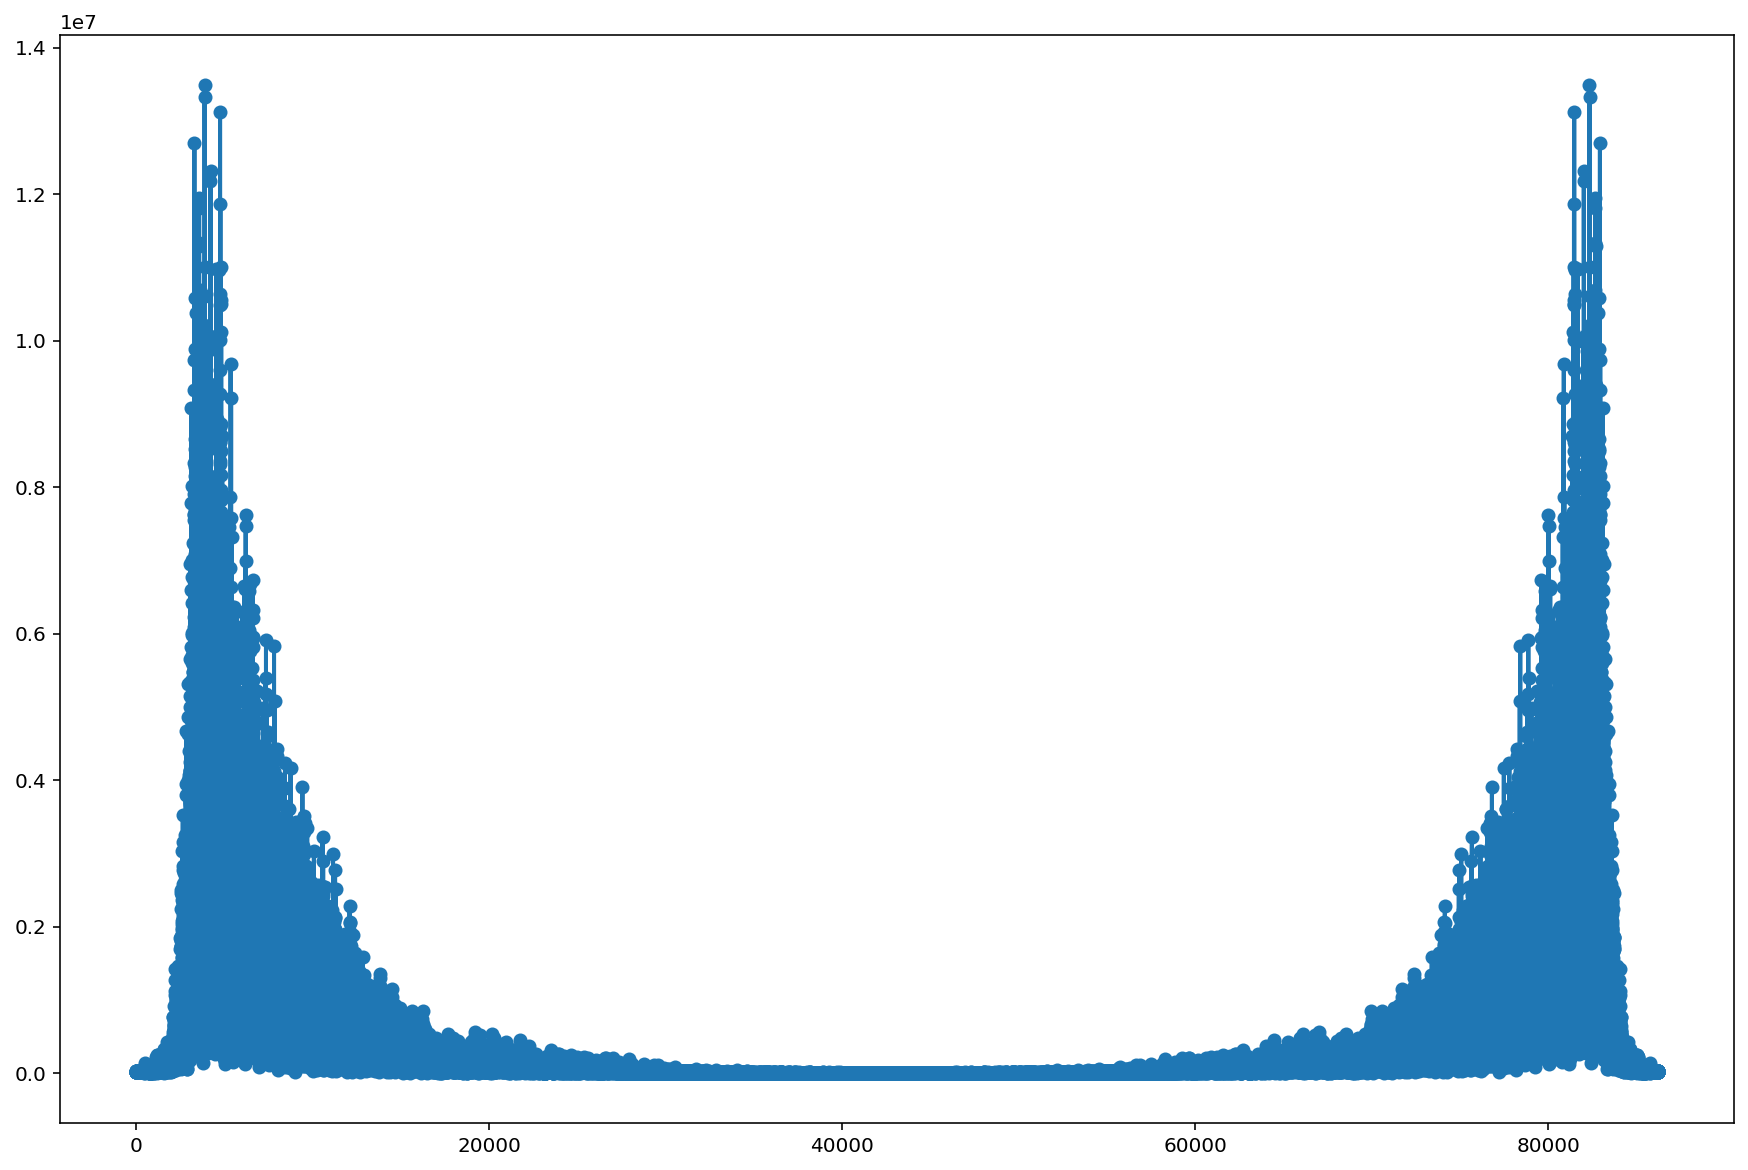

[0.00000000e+00 8.73845709e+08 9.25362980e+08 ... 1.94949800e+06
 1.83202671e+06 1.71381813e+06]


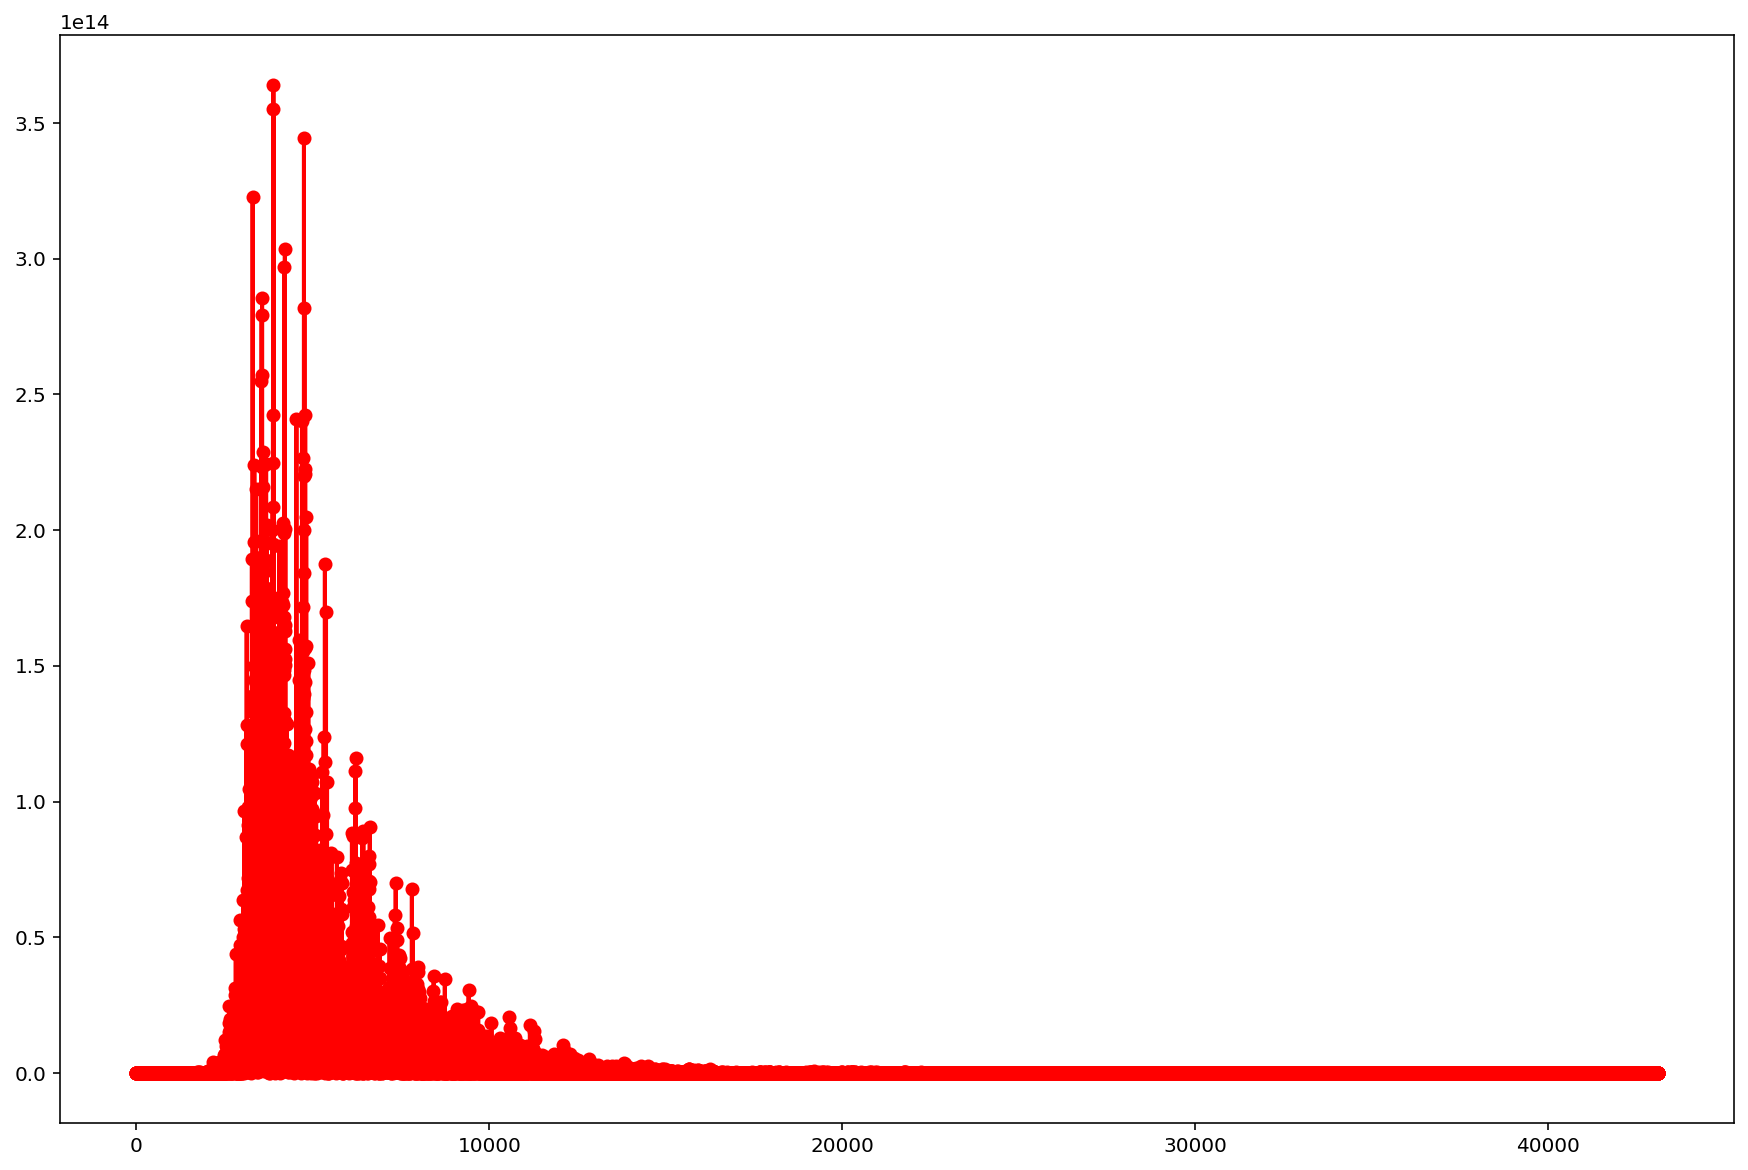

In [54]:
ft_light = np.fft.fft(light_data)
# print(ft)
print(ft_light.shape)
nn = ft_light.shape[0]

#plt.xlim(0,2000)
plt.plot(abs(ft_light),'o-',lw=2)
plt.show()

fAmp_light = np.zeros(nn//2)
for i in range(1,nn//2):
    fAmp_light[i] = abs(ft_light[i])**2 + abs(ft_light[nn-i])**2
print(fAmp_light)

#plt.xlim(800,1600)
plt.plot(fAmp_light,'ro-',lw=2)
plt.show()

In [55]:
def function(x, k):
    n = len(x)
    f1sum = 0
    f2sum = 0
        
    for j in range(n):
        f1 = x[j] * np.sin(2*np.pi*((j*k)/n))
        f1sum += f1
        
        f2 = x[j] * np.cos(2*np.pi*((j*k)/n))  
        f2sum += f2
        
       # print((f1sum)**2 + (f2sum)**2)
    
    return ((f1sum)**2 + (f2sum)**2)
    # j is the index of the point, x is the value of the point,
    # n is the number of data points, nu is the frequency, k is the frequency index

In [56]:
k1 = 0
k2 = len(light_data)

karr = []

for i in range(k1, k2):
    karr.append(i)

In [58]:
# for k in karr:
#     f = function(light_data, k)
#    # print(k,f)

#     plt.plot(k, f,'ro-')    

# #plt.ylim(0, 5*10**8)
# plt.show()

## Spectral Centroids

In [59]:
# load file with librosa
BHM, BHM_sr = librosa.load(BH)
# plasma2, plasma_sr = librosa.load(plasma)
ms2, ms_sr = librosa.load(ms)
lightning, lightning_sr = librosa.load(light)

In [60]:
frame_size = 1024
hl = 512

In [61]:
sc_BHM = librosa.feature.spectral_centroid(y=BHM,sr = BHM_sr, n_fft = frame_size, hop_length = hl)[0]
# sc_plasma = librosa.feature.spectral_centroid(y=plasma2, sr = plasma_sr, n_fft = frame_size, hop_length = hl)[0]
sc_ms = librosa.feature.spectral_centroid(y=ms2, sr = ms_sr,n_fft = frame_size, hop_length = hl)[0]
sc_light = librosa.feature.spectral_centroid(y=lightning,sr = lightning_sr, n_fft = frame_size, hop_length = hl)[0]


In [62]:
print(sc_BHM.shape)
# print(sc_plasma.shape)
print(sc_ms.shape)
print(sc_light.shape)

(1468,)
(712,)
(337,)


In [63]:
frames = range(len(sc_light))
t  = librosa.frames_to_time(frames)
t2 = librosa.frames_to_time(range(len(sc_BHM)))

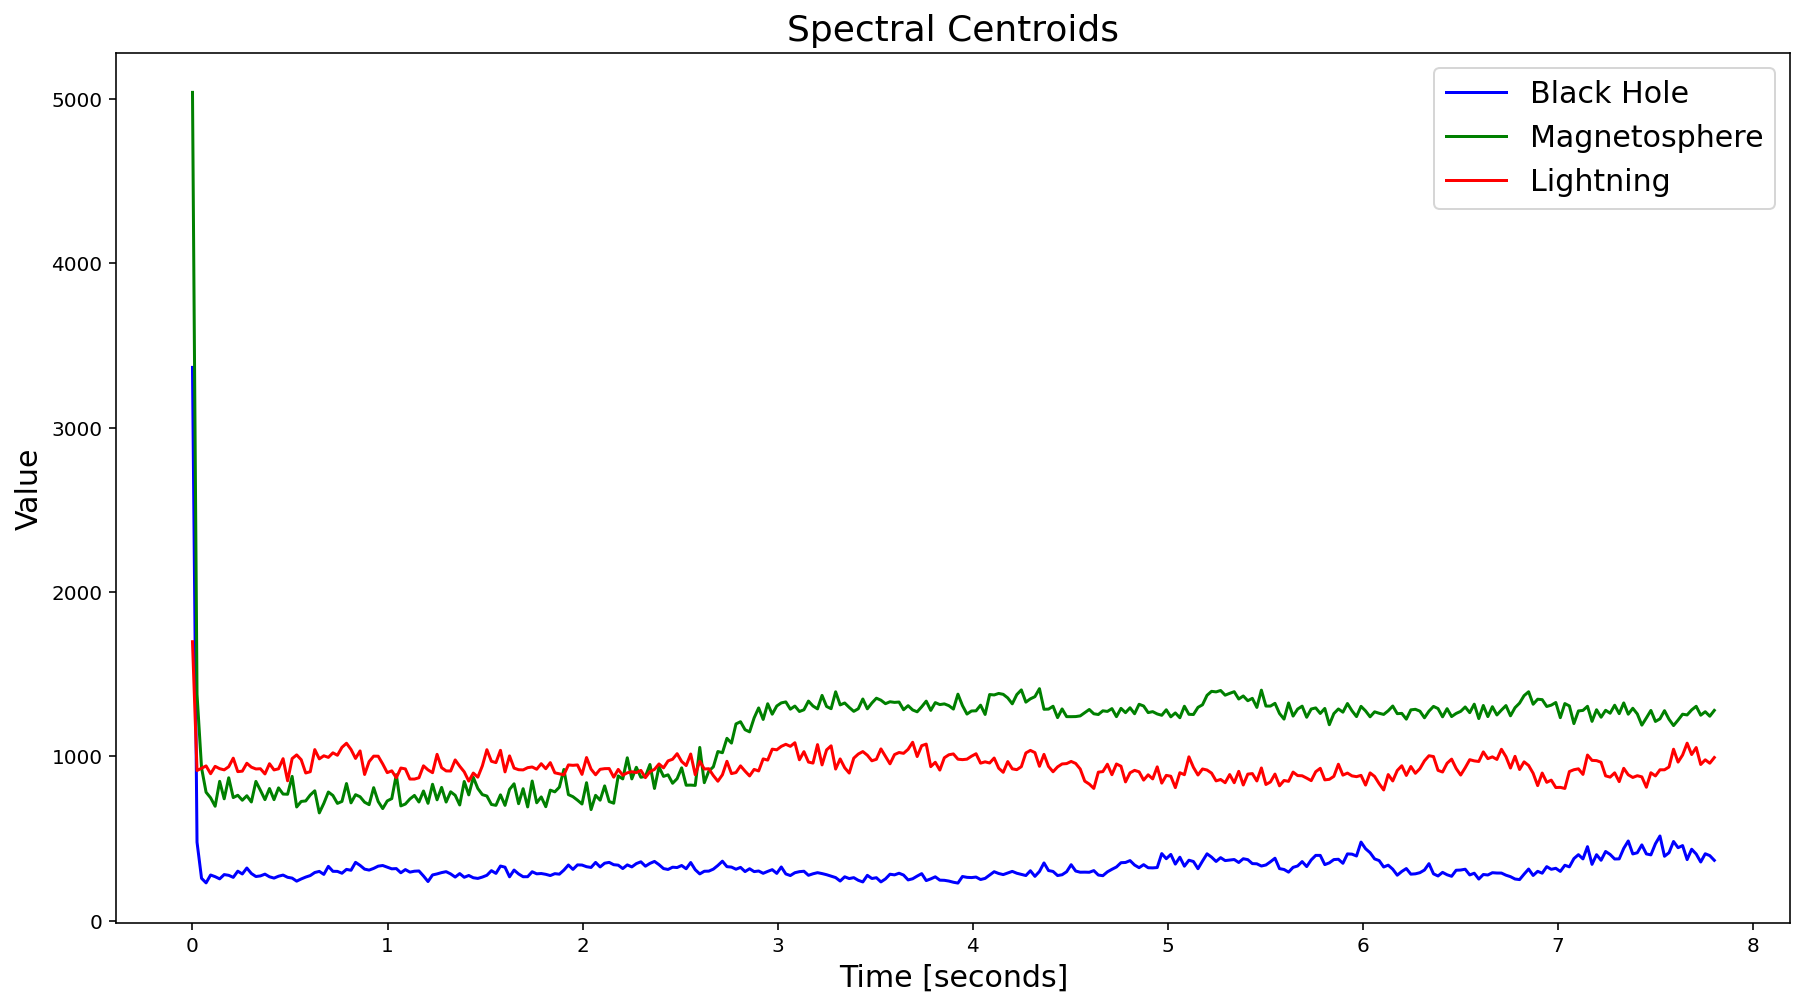

In [64]:
# visualize spectral centroid
plt.figure(figsize=(15, 8))

plt.plot(t, sc_BHM[0:337], 'b-', label='Black Hole')
plt.plot(t, sc_ms[0:337], 'g-', label='Magnetosphere')
plt.plot(t, sc_light, 'r-', label='Lightning')

plt.title('Spectral Centroids', fontsize=18)
plt.xlabel('Time [seconds]', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(fontsize=15)
plt.show()

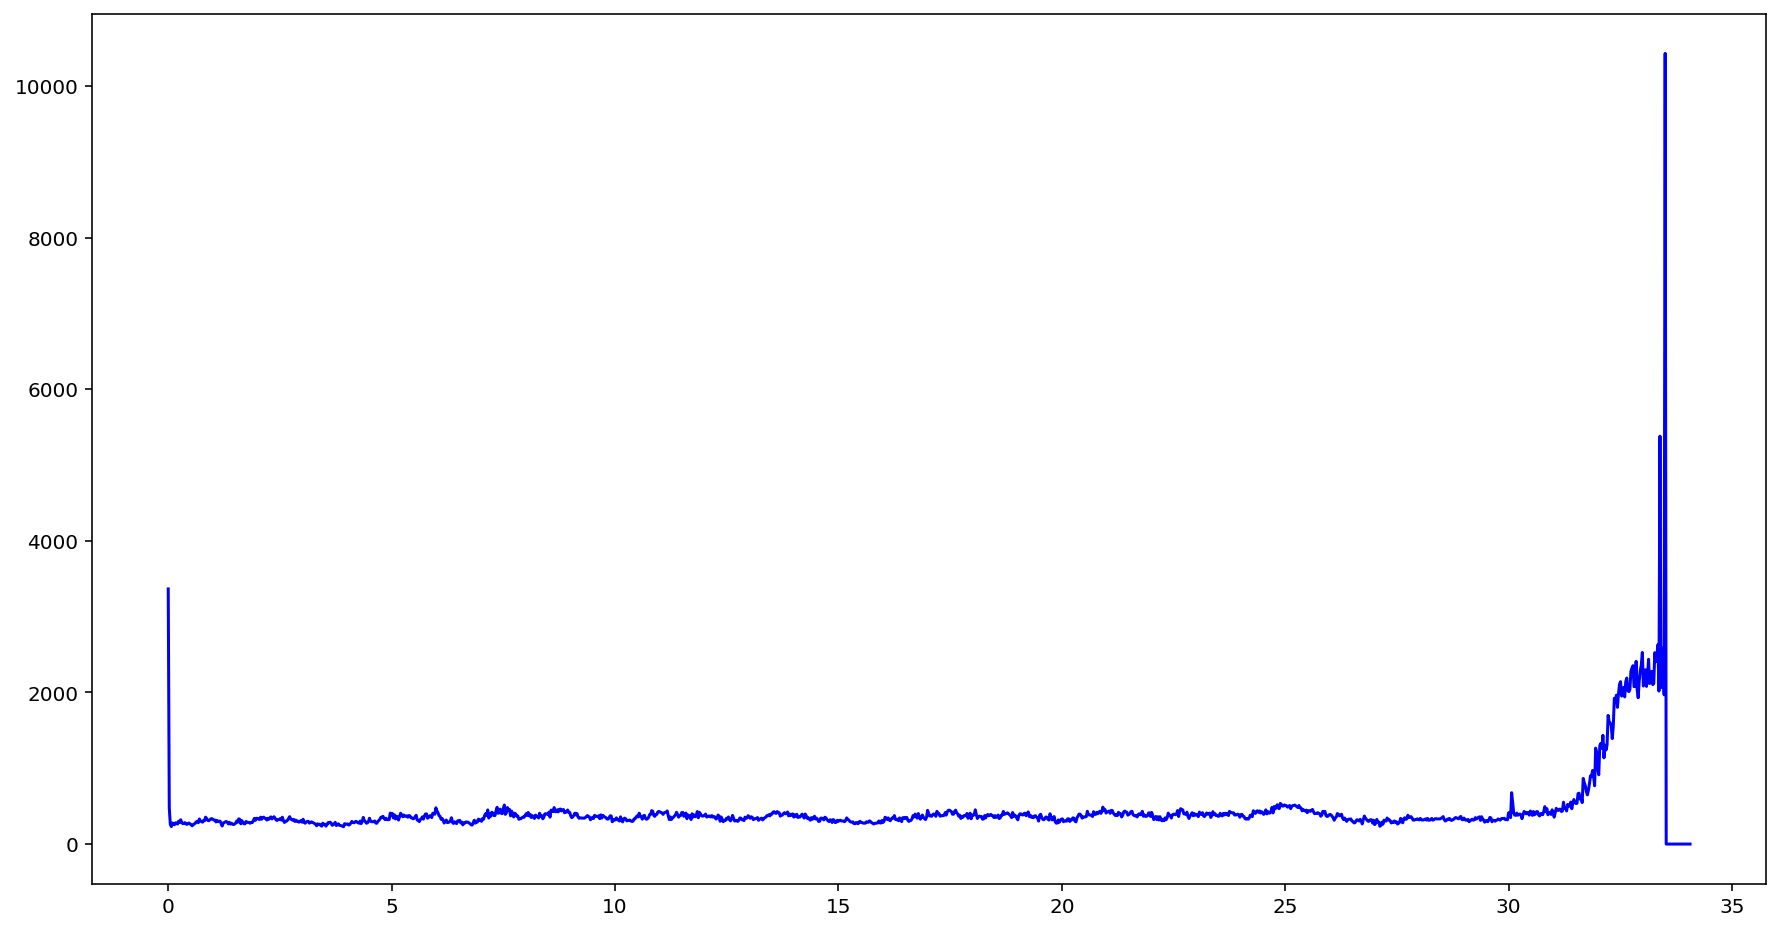

In [65]:
plt.figure(figsize=(15, 8))

plt.plot(t2,sc_BHM, 'b-', label='Black Hole')
#plt.plot(BHM_data,'r-')

## Calculate Bandwidth

In [66]:
bw_BHM = librosa.feature.spectral_bandwidth(y=BHM,sr = BHM_sr, n_fft = frame_size, hop_length = hl)[0]
bw_ms = librosa.feature.spectral_bandwidth(y=ms2, sr = ms_sr,n_fft = frame_size, hop_length = hl)[0]
bw_light = librosa.feature.spectral_bandwidth(y=lightning,sr = lightning_sr, n_fft = frame_size, hop_length = hl)[0]

In [67]:
print(bw_BHM.shape)
print(bw_ms.shape)
print(bw_light.shape)

(1468,)
(712,)
(337,)


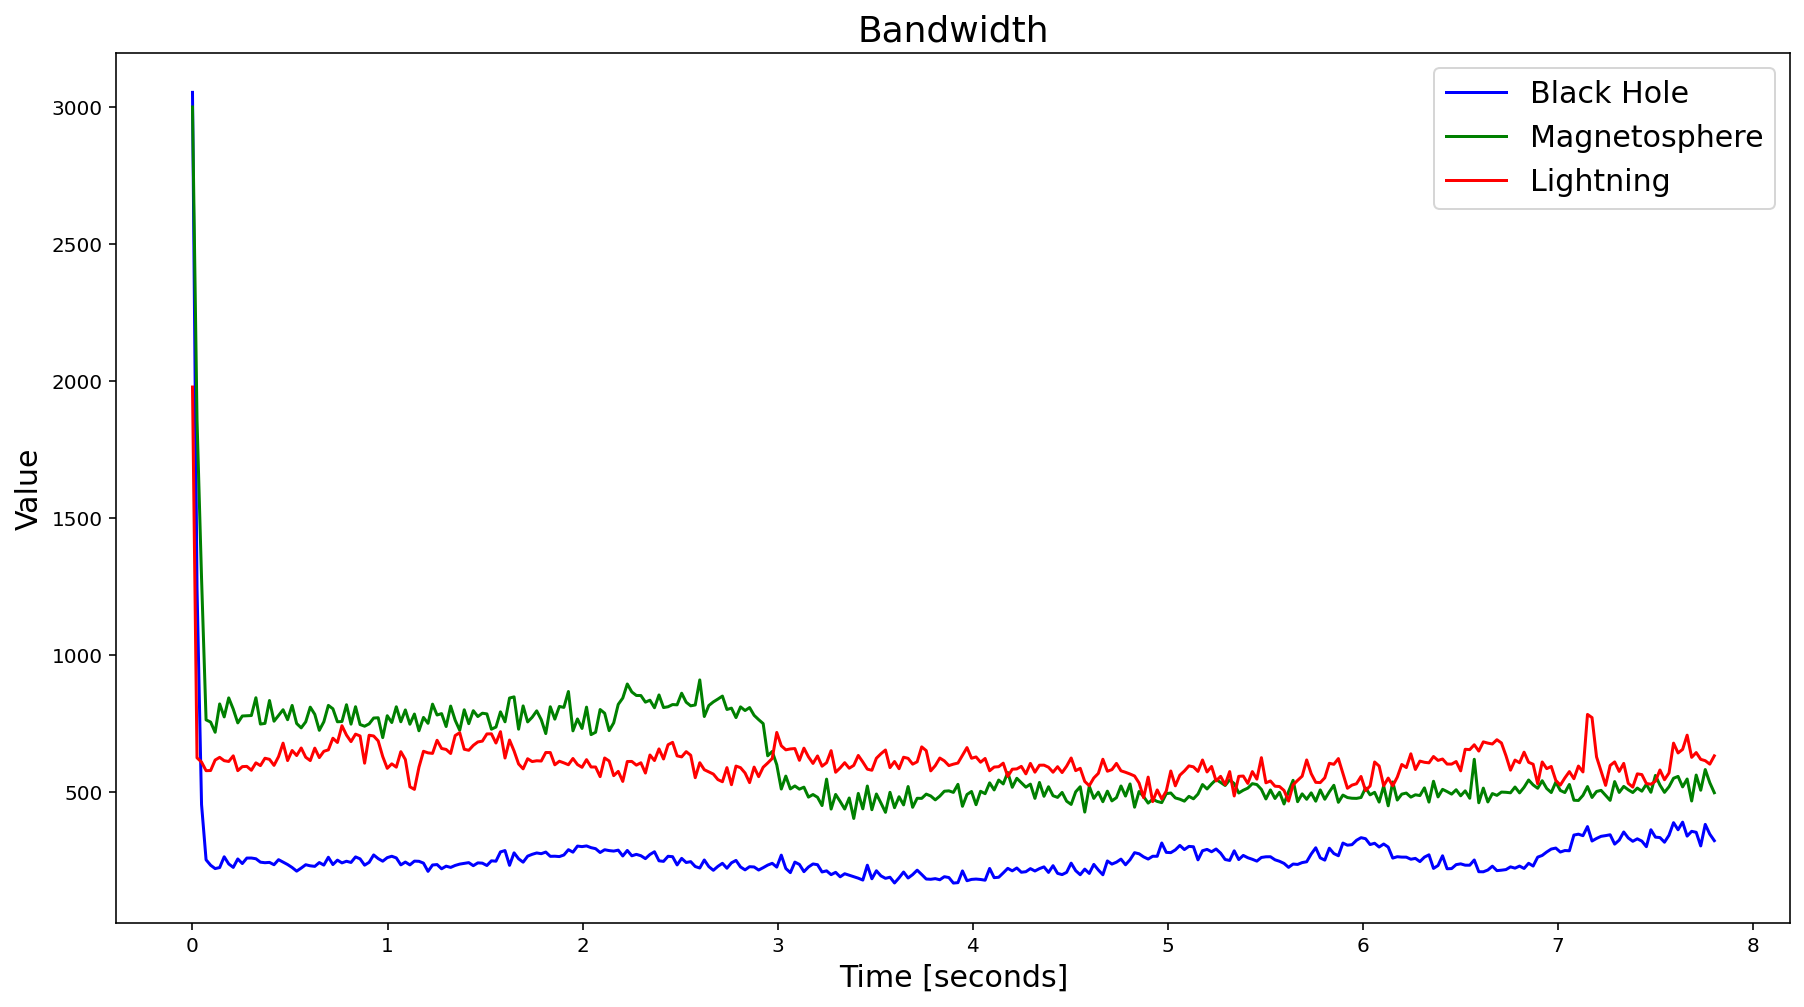

In [68]:
# visualize bandwidth
plt.figure(figsize=(15, 8))

plt.plot(t, bw_BHM[0:337], 'b-', label='Black Hole')
plt.plot(t, bw_ms[0:337], 'g-', label='Magnetosphere')
plt.plot(t, bw_light, 'r-', label='Lightning')

plt.title('Bandwidth', fontsize=18)
plt.xlabel('Time [seconds]', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [69]:
def function(x, k):
    n = len(x)
    f1sum = 0
    f2sum = 0
        
    for j in range(n):
        f1 = x[j] * np.sin(2*np.pi*((j*k)/n))
        f1sum += f1
        
        f2 = x[j] * np.cos(2*np.pi*((j*k)/n))  
        f2sum += f2
        
       # print((f1sum)**2 + (f2sum)**2)
    
    return ((f1sum)**2 + (f2sum)**2)
    # j is the index of the point, x is the value of the point,
    # n is the number of data points, nu is the frequency, k is the frequency index

In [70]:
k1 = 15000
k2 = 20000

karr = []

for i in range(k1, k2):
    karr.append(i)

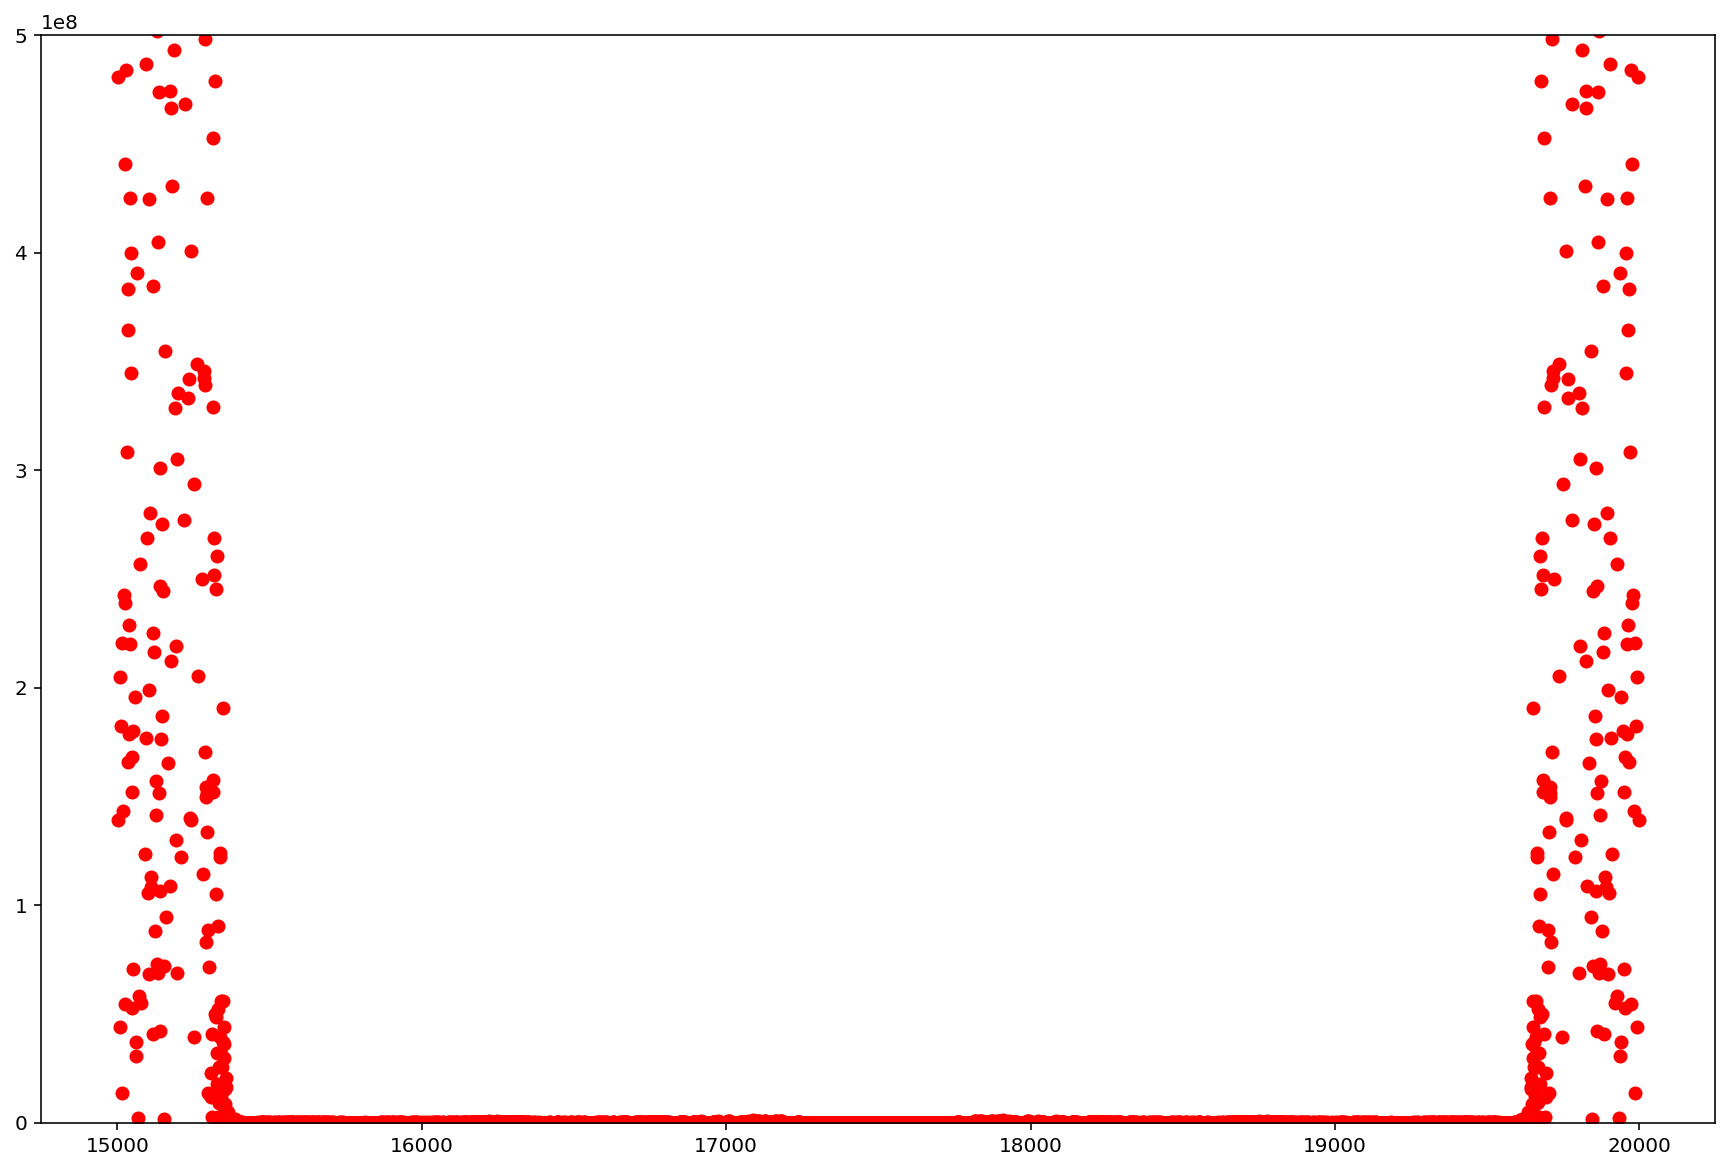

In [72]:
for k in karr:
    f = function(plasma_data[15000:20000], k)
   # print(k,f)

    plt.plot(k, f,'ro-')    

plt.ylim(0, 5*10**8)
plt.show()